In [2]:
import torch as th
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad

In [3]:
def snakeStep(snakepos, extgrad, cmat, stepsz):
    return th.einsum("lkd,kd->ld", [cmat, snakepos - stepsz * extgrad])

In [137]:
class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, gimgN, gimgW, step_type="original"):
        super().__init__(graph, crop, stepsz, alpha, beta, ndims=2)
        self.w = th.ones(len(self.s), 1, dtype=th.float32) * 10.0  # Initial width
        self.step_type = step_type
        if self.s.is_cuda:
            self.s = self.s.cuda()
        
        self.gimgN = gimgN  # Gradient image (2 x H x W)
        self.gimgW = gimgW  # Gradient image (2 x H x W)

    def cuda(self):
        super().cuda()
        if self.gimgN is not None:
            self.gimgN = self.gimgN.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()

    def _compute_normals(self, pos_xy):
        """Compute normals for the centerline using finite differences."""
        k = pos_xy.size(0)
        tangent = th.zeros_like(pos_xy)
        
        if k > 1:
            # forward/backward differences for endpoints
            tangent[0] = pos_xy[1] - pos_xy[0]
            tangent[-1] = pos_xy[-1] - pos_xy[-2]
            if k > 2:
                # central differences for interior points
                tangent[1:-1] = pos_xy[2:] - pos_xy[:-2]
        
        # rotate tangent 90 degrees to get normal
        normals = th.stack([-tangent[:, 1], tangent[:, 0]], dim=1)
        norm = th.norm(normals, dim=1, keepdim=True) + 1e-8
        return normals / norm
    
    def _compute_normals_complex(self, pos_xy):
        k = pos_xy.size(0)
        normals = th.zeros_like(pos_xy)
        eps = 1e-8  # small constant to avoid division by zero

        # Helper function: rotate a 2D vector 90° (choose clockwise or counterclockwise)
        def perp(vec):
            return th.tensor([-vec[1], vec[0]], dtype=vec.dtype, device=vec.device)

        # First endpoint: use the edge to the next point
        if k >= 2:
            tang = pos_xy[1] - pos_xy[0]
            tang_norm = th.norm(tang) + eps
            tang = tang / tang_norm
            normals[0] = perp(tang)
        
        # Interior points
        for i in range(1, k-1):
            # Edge from previous point and edge to next point
            t1 = pos_xy[i] - pos_xy[i-1]
            t2 = pos_xy[i+1] - pos_xy[i]
            n1 = th.norm(t1) + eps
            n2 = th.norm(t2) + eps
            t1 = t1 / n1
            t2 = t2 / n2

            # Average the two normalized tangents.
            tangent = t1 + t2
            
            # In case the two directions nearly cancel (sharp corner), fall back to one of them.
            if th.norm(tangent) < 1e-5:
                tangent = t1

            tangent = tangent / (th.norm(tangent) + eps)
            normals[i] = perp(tangent)
        
        # Last endpoint: use the edge from the previous point
        if k >= 2:
            tang = pos_xy[-1] - pos_xy[-2]
            tang = tang / (th.norm(tang) + eps)
            normals[-1] = perp(tang)

        return normals

    def step(self):
        if len(self.s) == 0:
            return

        # centerline positions and normals
        pos_xy = self.s
        normals = self._compute_normals_complex(pos_xy)
        
        # calculate edge positions
        v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
        v_R = pos_xy + self.w * normals / 2

        # Sample gradients at edges (2D only)
        grad_L = cmptExtGrad(v_L, self.gimgN) # grad values at left outline
        grad_R = cmptExtGrad(v_R, self.gimgN)

        grad_centerline = cmptExtGrad(pos_xy, self.gimgN)

        # Centerline gradient: sum of edge gradients
        grad_xy = (grad_L + grad_R) / 2
        # update centerline using Snake's mechanism, when the centerline is in a place where grad = 0
        # look at the outline gradients
        # this can happen when centerline is in the middle of dist map (look at the plot of grad distmap)
        if np.sum(abs(grad_centerline.numpy())) > np.sum(abs(grad_xy.numpy())):
            super().step(grad_centerline)
        else:
            super().step(grad_xy)
        #super().step(grad_centerline)
        return self.s
    
    def stiff_step(self, niter):
        if len(self.s) == 0:
            return

        # centerline positions and normals
        pos_xy = self.s
        normals = self._compute_normals_complex(pos_xy)
        
        # calculate edge positions
        v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
        v_R = pos_xy + self.w * normals / 2

        # Sample gradients at edges (2D only)
        grad_L = cmptExtGrad(v_L, self.gimgN) # grad values at left outline
        grad_R = cmptExtGrad(v_R, self.gimgN)

        grad_centerline = cmptExtGrad(pos_xy, self.gimgN)

        # Centerline gradient: sum of edge gradients
        grad_xy = (grad_L + grad_R) / 2

        grad_cent_average = th.mean(grad_centerline, dim=0, keepdim=True)
        grad_xy_average = th.mean(grad_xy, dim=0, keepdim=True)
        # update the centerline according to avergae gradient
        # just shifting the snake
        if niter < 500:
            self.s = self.s - self.stepsz * grad_cent_average
        else:
            self.s = self.s - self.stepsz * grad_xy_average
        #self.s = self.s - self.stepsz * grad_xy
        return self.s
    
    def step_widths(self):
        if len(self.s) == 0:
            return

        # centerline positions and normals
        pos_xy = self.s
        normals = self._compute_normals_complex(pos_xy)
        
        # calculate edge positions
        v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
        v_R = pos_xy + self.w * normals / 2

        # Sample gradients at edges (2D only)
        grad_L = cmptExtGrad(v_L, self.gimgW) # grad values at left outline
        grad_R = cmptExtGrad(v_R, self.gimgW)

        # Width gradient: projection of (grad_L - grad_R) onto normals
        grad_w = th.sum((grad_L - grad_R) * normals, dim=1, keepdim=True) / 2

        # update width with separate internal energy (simplified version / can add different internal energies for wdith)
        # for example an internal energy that is dependent on width changes
        w_stepsz = self.stepsz * 0.1  # Smaller step for stability
        self.w = (1 - w_stepsz * self.alpha) * self.w + w_stepsz * grad_w / 2

        return self.s

    def optim(self, niter):
        if self.step_type == "stiff":
            for i in range(niter):
                #self.step()
                if i % 2 == 0:
                    self.stiff_step(i)
                else:
                    self.step_widths()
        elif self.step_type == "original":
            for i in range(niter):
                if i % 2 == 0:
                    self.step()
                else:
                    self.step_widths()
        elif self.step_type == "combined":
            for i in range(niter):
                self.step()
                self.step_widths()
        return self.s
    
    def get_s(self):
        return self.s
    
    def get_w(self):
        return self.w
    
    def set_w(self, w):
        self.w = w

In [5]:
import networkx as nx
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr

In [6]:
import matplotlib.pyplot as plt

def show(img,title,graph=None, snake=None, widths=None):   
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.show()

tensor([[5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.]])


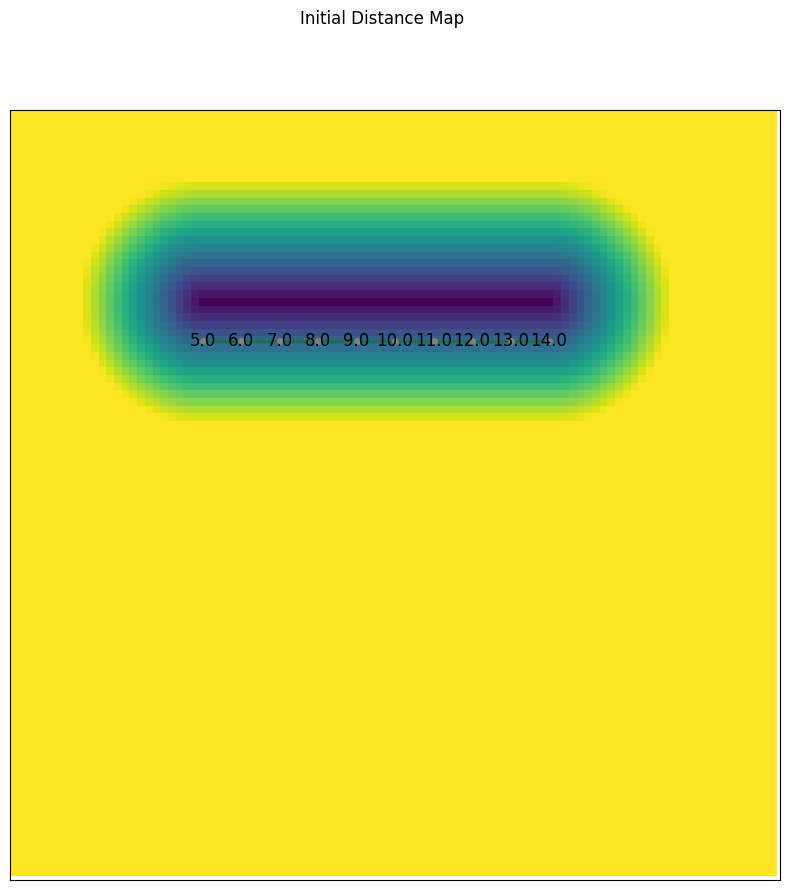

tensor([[25.0000, 26.6386],
        [25.0000, 30.0000],
        [25.0000, 35.0000],
        [25.0000, 40.0000],
        [25.0000, 45.0000],
        [25.0000, 50.0000],
        [25.0000, 55.0000],
        [25.0000, 60.0000],
        [25.0000, 65.0000],
        [25.0000, 68.3614]])
tensor([[4.0448],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0448]])


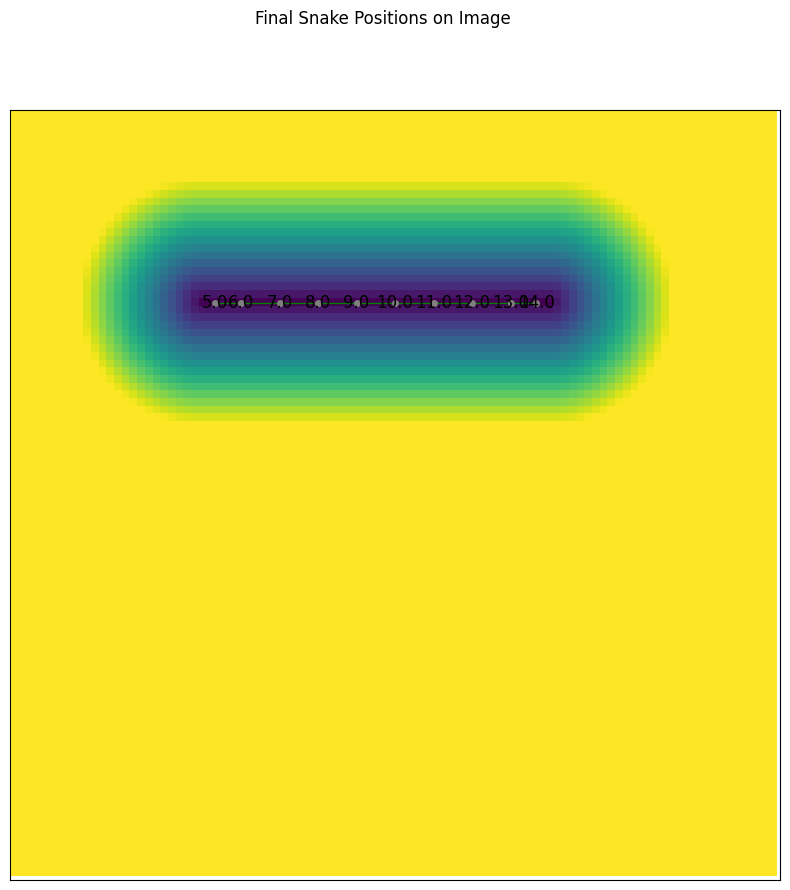

In [7]:
g = nx.Graph()
for i in range(25,75,5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=Snake(g,crop,stepsz,alpha,beta,ndims)

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge)
pred_initial=pred_perfect.clone()[None,None]
pred = pred_initial.clone()
gr = nx.Graph()
for i in range(25,75,5):  # Start from 0
    gr.add_node(i/5, pos=np.array([30, i]))
    if i > 25:
        gr.add_edge(i/5, i/5 - 1)

fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimg = cmptGradIm(pred,fltrtr)
extgradfac=1.0
gimg = gimg[0]

croprib=[slice(0,200), slice(0,200)]
sa=RibbonSnake(gr,croprib,stepsz,alpha,beta,gimg)

print(sa.w)
# Plot the image
show(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sa.getGraph())

last = sa.optim(100)
print(last)
print(sa.w)

import matplotlib.pyplot as plt

# Get the final positions of the snake nodes
final_positions = sa.get_s().detach().cpu().numpy()

# Plot the snake nodes
show(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sa.getGraph())


tensor([[5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.],
        [5.]])


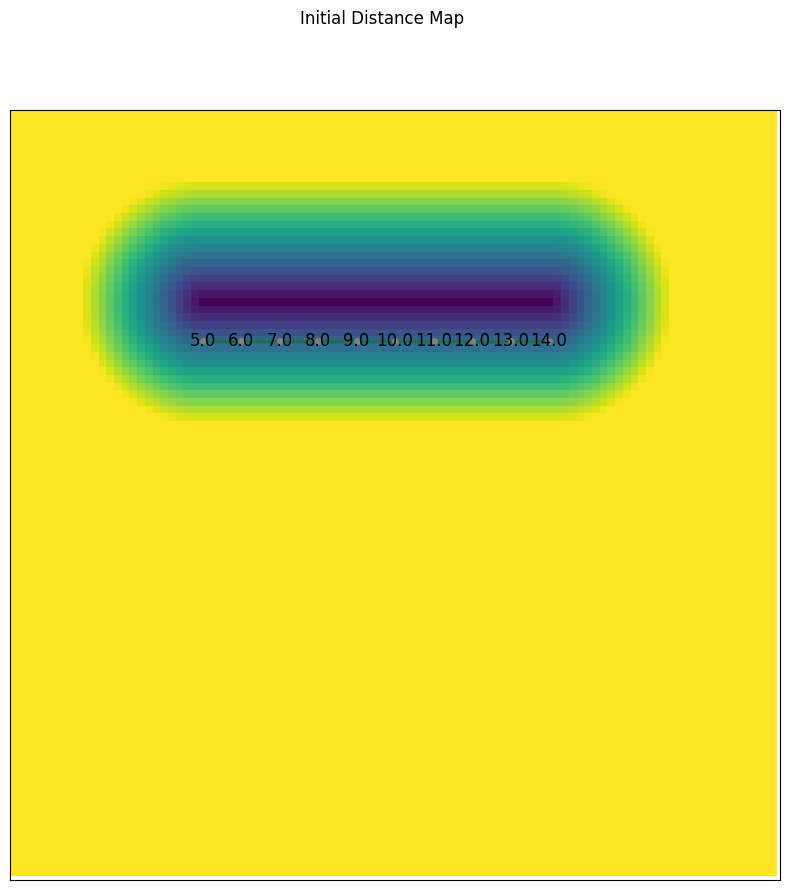

tensor([[25.0000, 26.6386],
        [25.0000, 30.0000],
        [25.0000, 35.0000],
        [25.0000, 40.0000],
        [25.0000, 45.0000],
        [25.0000, 50.0000],
        [25.0000, 55.0000],
        [25.0000, 60.0000],
        [25.0000, 65.0000],
        [25.0000, 68.3614]])
tensor([[4.0448],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0358],
        [4.0448]])


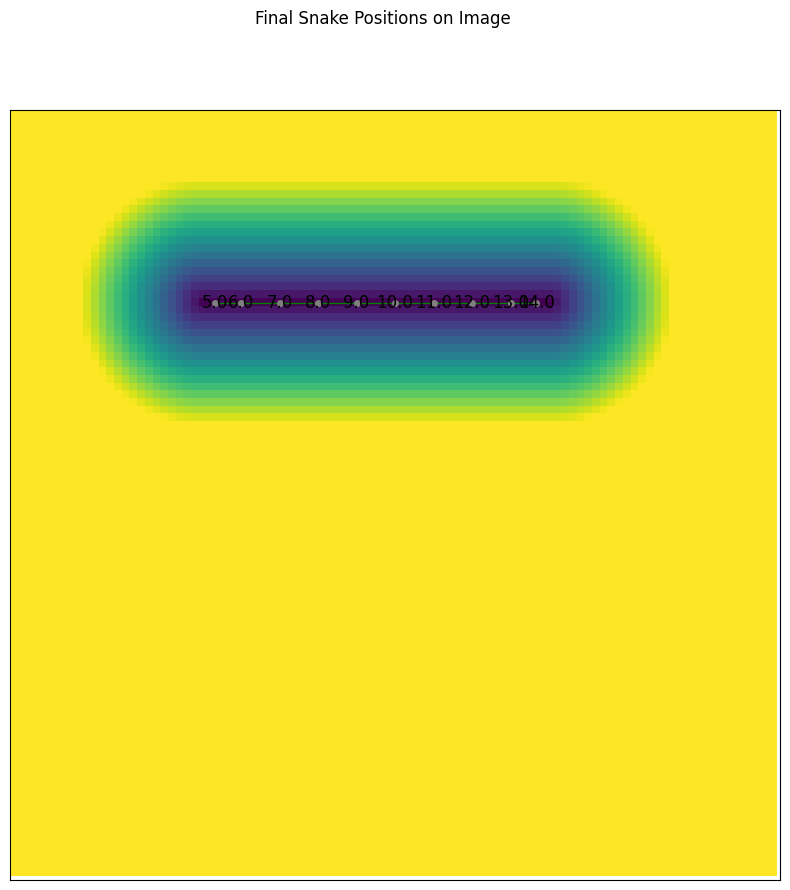

In [8]:
# ribbon snake hareket ediyor mu testi

g = nx.Graph()
for i in range(25,75,5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=Snake(g,crop,stepsz,alpha,beta,ndims)

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4
 
pred_perfect=s.renderDistanceMap(size,cropsz,dmax,maxedge)
pred_initial=pred_perfect.clone()[None,None]
pred = pred_initial.clone()
gr = nx.Graph()
for i in range(25,75,5):  # Start from 0
    gr.add_node(i/5, pos=np.array([30, i]))
    if i > 25:
        gr.add_edge(i/5, i/5 - 1)

fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimg = cmptGradIm(pred,fltrtr)
extgradfac=1.0
gimg = gimg[0]

croprib=[slice(0,200), slice(0,200)]
sa=RibbonSnake(gr,croprib,stepsz,alpha,beta,gimg)

print(sa.w)
# Plot the image
show(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sa.getGraph())

last = sa.optim(100)
print(last)
print(sa.w)

import matplotlib.pyplot as plt

# Get the final positions of the snake nodes
final_positions = sa.get_s().detach().cpu().numpy()

# Plot the snake nodes
show(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sa.getGraph())


In [9]:
from scipy.linalg import inv
from Codes.Losses.snake import Snake
import torch

def invertALambdaI(A, stepsz):
    """
    Inverts (I + stepsz * A), where A is a square matrix.
    """
    return inv(np.eye(A.shape[0]) + stepsz * A)

def render_distance_map_3d(samples_with_widths, size3d, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy, cz], width is scalar
    :param size3d: (dimX, dimY, dimZ)
    :param iscuda: Whether to return a CUDA tensor
    :return: A 3D distance map (torch float tensor) of shape [dimX, dimY, dimZ]
             distanceMap[x, y, z] = 0 if inside the snake,
                                    or distance to boundary if outside.
    """
    dimX, dimY, dimZ = size3d
    dist_volume = np.zeros((dimX, dimY, dimZ), dtype=np.float32)

    centers = []
    radii   = []
    for (pos, width) in samples_with_widths:
        cx, cy, cz = pos
        r = max(0.0, width * 0.5)
        centers.append((cx, cy, cz))
        radii.append(r)

    bigval = 1e6
    for x in range(dimX):
        for y in range(dimY):
            for z in range(dimZ):
                min_bd = bigval
                for i in range(len(centers)):
                    cx, cy, cz = centers[i]
                    r = radii[i]
                    dx = (x - cx)
                    dy = (y - cy)
                    dz = (z - cz)
                    dist_center = np.sqrt(dx*dx + dy*dy + dz*dz)
                    boundary_dist = dist_center - r
                    if boundary_dist < min_bd:
                        min_bd = boundary_dist

                dist_volume[x, y, z] = 0.0 if (min_bd < 0.0) else min_bd

    dist_map_t = torch.from_numpy(dist_volume).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def render_distance_map_2d(samples_with_widths, size, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map (torch float tensor) of shape [size[0], size[1]]
             distanceMap[x, y] = 0 if inside the snake,
                                 or Euclidean distance to boundary if outside.
    """
    w, h = size  # interpret size as (width, height)
    dist_map = np.zeros((w, h), dtype=np.float32)

    # For efficiency, we might pre-store centers and radii
    centers = []
    radii   = []
    for (pos, width) in samples_with_widths:
        cx, cy = pos
        r = max(0.0, width * 0.5)
        centers.append((cx, cy))
        radii.append(r)

    bigval = 1e6  # a large number to initialize the outside distance
    for x in range(w):
        for y in range(h):
            # We'll compute min boundary-dist across all samples
            min_bd = bigval
            for i in range(len(centers)):
                cx, cy = centers[i]
                r      = radii[i]
                dx = (x - cx)
                dy = (y - cy)
                dist_center = np.sqrt(dx*dx + dy*dy)
                boundary_dist = dist_center - r
                if boundary_dist < min_bd:
                    min_bd = boundary_dist

            # If the min boundary-dist < 0 => inside snake => distance=0
            dist_map[x, y] = 0.0 if (min_bd < 0.0) else min_bd

    # Convert to torch
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

class Ribbon_Snake(Snake):
    def __init__(
        self,
        graph,
        crop,
        stepsz,
        alpha,
        beta,
        ndims,
        num_samples=10,
        alpha_w=0.01,
        beta_w=0.01,
        stepsz_width=0.1
    ):
        """
        Extended snake that also has 'width' values along the sampled centerline.

        :param graph:     The original networkx graph (with node["pos"] in ndims).
        :param crop:      Tuple of slices for cropping the graph (same as base Snake).
        :param stepsz:    Step size for the snake's positions (implicit update).
        :param alpha:     Pairwise energy coefficient for node positions.
        :param beta:      Curvature energy coefficient for node positions.
        :param ndims:     Number of dimensions (2 or 3).
        :param num_samples: Number of samples to take between each control-point edge.
        :param alpha_w:   Pairwise smoothness for the widths.
        :param beta_w:    Curvature smoothness for the widths.
        :param stepsz_width: Step size for the widths (implicit update).
        """
        super(Ribbon_Snake, self).__init__(graph, crop, stepsz, alpha, beta, ndims)

        self.num_samples   = num_samples
        self.samples       = self.create_samples()  # shape: (N, ndims)
        self.widths        = np.ones((len(self.samples),), dtype=np.float32)

        self.alpha_w       = alpha_w
        self.beta_w        = beta_w
        self.stepsz_width  = stepsz_width

        # Build the width-smoothing matrix (A_w) for these samples
        A_w = self.getA_width()
        # Invert (I + stepsz_width * A_w) for an implicit step
        self.C_w = invertALambdaI(A_w, self.stepsz_width)  # shape: (N, N)

        # Convert widths to torch
        self.widths_torch = torch.from_numpy(self.widths).float()

        # We'll keep track of which widths are "fixed" or not
        # (In typical usage, we won't fix widths, but we might have boundary conditions.)
        self.fixedW = torch.zeros_like(self.widths_torch, dtype=torch.bool)

        self.iscuda = False

    def cuda(self):
        super(Ribbon_Snake, self).cuda()  # moves self.c, self.s, etc. to GPU
        self.C_w  = torch.from_numpy(self.C_w).float().cuda()
        self.widths_torch = self.widths_torch.cuda()
        self.fixedW = self.fixedW.cuda()
        self.iscuda = True

    def create_samples(self):
        """
        Samples points between edges.
        Each edge from u->v is divided into num_samples segments.
        Returns an array of shape (N, ndims).
        """
        samples = []
        for (u, v) in self.h.edges:
            pos_u = self.h.nodes[u]["pos"]
            pos_v = self.h.nodes[v]["pos"]
            # Create a linear interpolation from u -> v
            for t in np.linspace(0, 1, self.num_samples, endpoint=False):
                sample_pos = (1 - t) * np.array(pos_u) + t * np.array(pos_v)
                samples.append(sample_pos)
        return np.array(samples, dtype=np.float32)

    # ------------------------------------------------------------------
    #  (A) Width-Smoothing Matrix (A_w)
    # ------------------------------------------------------------------

    def getA_width(self):
        """
        Returns an NxN matrix A_w that encodes pairwise and curvature
        smoothing along each edge's sample chain.

        For simplicity, each edge's samples are treated as an independent
        1D chain. We do NOT yet link widths across edges if they share a node.

        The energy is:
            E_w = alpha_w * sum_{i,i+1} (w_i - w_{i+1})^2
                + beta_w  * sum_{i-1,i,i+1} (w_{i-1} - 2 w_i + w_{i+1})^2
        """
        # We'll build block-diagonal submatrices for each edge, then combine.
        # First, we must figure out how many samples belong to each edge:
        edge_sizes = []
        for _ in self.h.edges:
            edge_sizes.append(self.num_samples)
        # total samples:
        total_samples = sum(edge_sizes)

        # Initialize big NxN
        A_w = np.zeros((total_samples, total_samples), dtype=np.float32)

        # Now, fill each block along the diagonal
        start_idx = 0
        for e_size in edge_sizes:
            end_idx = start_idx + e_size
            # Fill the sub-block for [start_idx : end_idx]
            A_sub = self.build_1d_chain_A(e_size, self.alpha_w, self.beta_w)
            A_w[start_idx:end_idx, start_idx:end_idx] = A_sub
            start_idx = end_idx

        return A_w

    @staticmethod
    def build_1d_chain_A(n, alpha_w, beta_w):
        """
        Builds an n x n matrix for a 1D chain of length n.
        Pairwise: alpha_w * sum (w_i - w_{i+1})^2
        Curvature: beta_w * sum (w_{i-1} - 2w_i + w_{i+1})^2
        """
        A = np.zeros((n, n), dtype=np.float32)

        # -- pairwise (alpha_w) --
        for i in range(n - 1):
            A[i, i]     += alpha_w
            A[i, i + 1] -= alpha_w
            A[i + 1, i] -= alpha_w
            A[i + 1, i+1] += alpha_w

        # -- curvature (beta_w) --
        for i in range(1, n - 1):
            # w_i with itself
            A[i, i] += 4 * beta_w

            # w_i with neighbors
            A[i, i - 1] += -2 * beta_w
            A[i, i + 1] += -2 * beta_w

            # neighbors with w_i
            A[i - 1, i] += -2 * beta_w
            A[i + 1, i] += -2 * beta_w

            # neighbors among themselves
            A[i - 1, i - 1] += beta_w
            A[i + 1, i + 1] += beta_w
            A[i - 1, i + 1] += beta_w
            A[i + 1, i - 1] += beta_w

        return A

    # ------------------------------------------------------------------
    #  (B) Width Update Step
    # ------------------------------------------------------------------

    def step_widths(self, grad_widths):
        """
        grad_widths: torch tensor of shape (N,)
                     This is the external gradient w.r.t. each width sample.
        We do an implicit step:
          w_new = C_w * (w_old - stepsz_width * grad_widths)
        where C_w = (I + stepsz_width * A_w)^{-1}.
        """
        # 1. Zero out gradient for "fixed" widths
        grad_widths[self.fixedW] = 0.0

        # 2. Do the matrix-vector multiply:
        w_old = self.widths_torch
        g_w   = grad_widths

        w_new_np = np.dot(self.C_w, (w_old.cpu().numpy() - self.stepsz_width * g_w.cpu().numpy()))
        w_new = torch.from_numpy(w_new_np).float()

        # 3. Assign
        self.widths_torch = w_new
        if self.iscuda:
            self.widths_torch = self.widths_torch.cuda()

    def get_widths(self):
        """Return the current widths as a numpy array (CPU)."""
        return self.widths_torch.detach().cpu().numpy()

    def set_widths(self, widths):
        """Set widths from a numpy array or torch array."""
        if isinstance(widths, np.ndarray):
            widths = torch.from_numpy(widths).float()
        self.widths_torch = widths
        if self.iscuda:
            self.widths_torch = self.widths_torch.cuda()

    def get_samples_with_widths(self):
        """
        Returns a list of (pos, width) for each sample.
        Positions are in CPU numpy format (just for convenience).
        """
        pos_np = self.samples  # these are CPU by default
        w_np   = self.get_widths()
        return list(zip(pos_np, w_np))

    def render_distance_map(self, size, cropsz, dmax, maxedgelen):
        """
        Renders a pseudo-signed distance map:
          - 0 for voxels/pixels inside the ribbon
          - positive distance outside
        'size' should be either (W,H) for 2D or (X,Y,Z) for 3D
        'dmax' can be used to clamp the maximum distance if desired.
        This function returns a torch float tensor of shape 'size'.
        """
        samples_with_widths = self.get_samples_with_widths()

        if self.ndims == 2:
            dist_map = render_distance_map_2d(samples_with_widths, size, iscuda=self.iscuda)
        elif self.ndims == 3:
            dist_map = render_distance_map_3d(samples_with_widths, size, iscuda=self.iscuda)
        else:
            raise ValueError("render_distance_map only supports ndims=2 or 3.")

        # Optionally clamp if we want a max distance
        if dmax is not None:
            dist_map = torch.clamp(dist_map, max=dmax)

        return dist_map

C:\Users\serta\AppData\Local\Temp\ipykernel_17924\861094594.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))


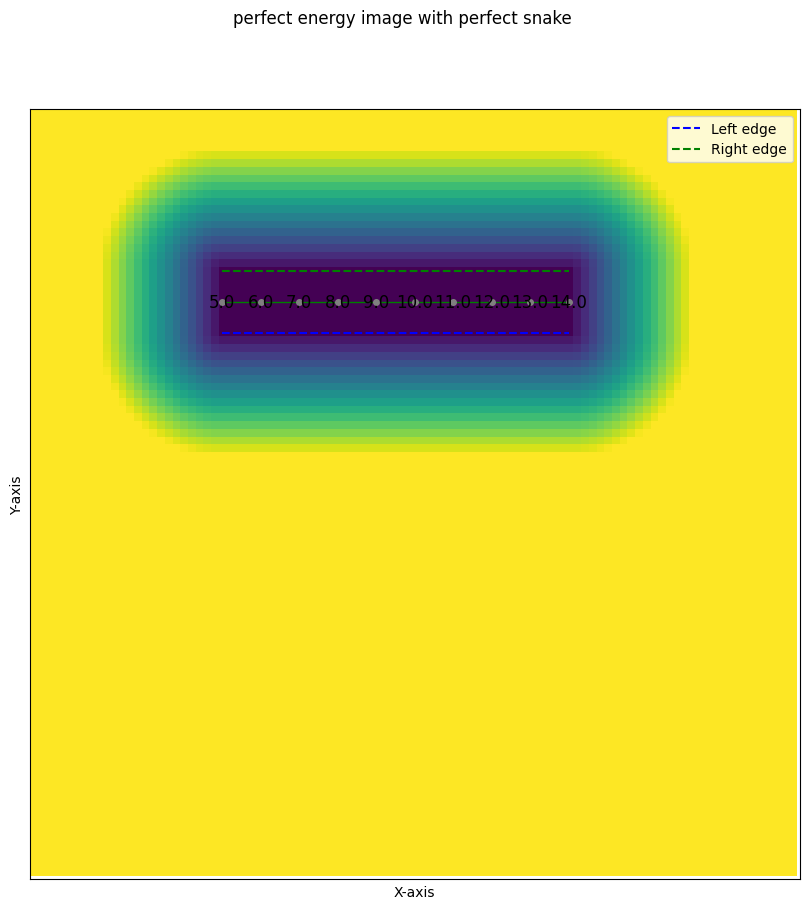

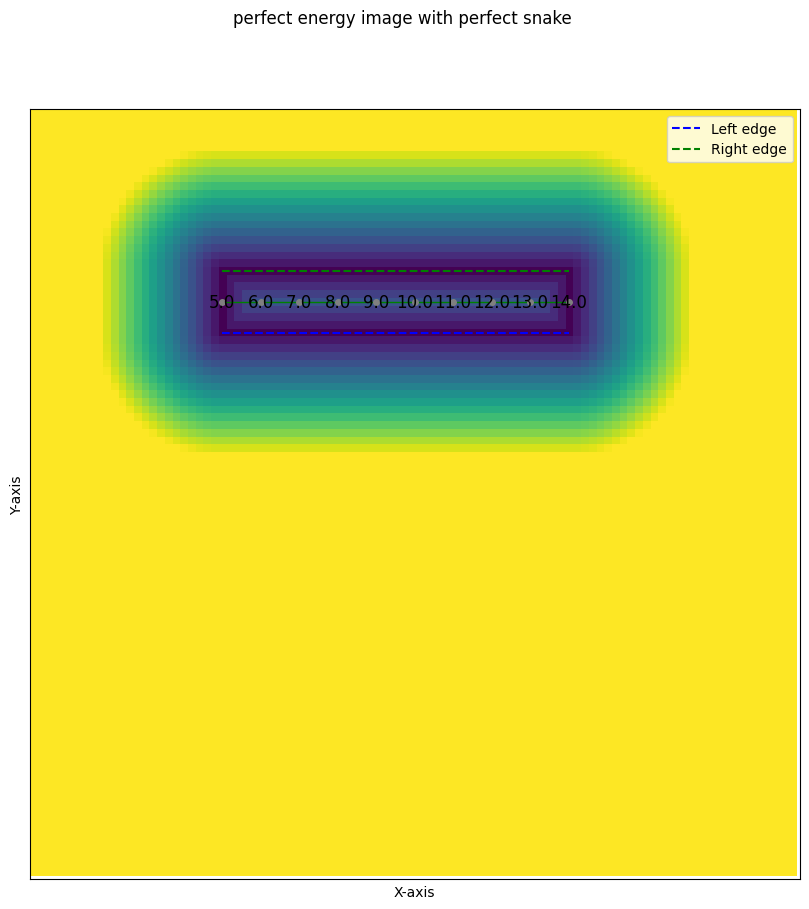

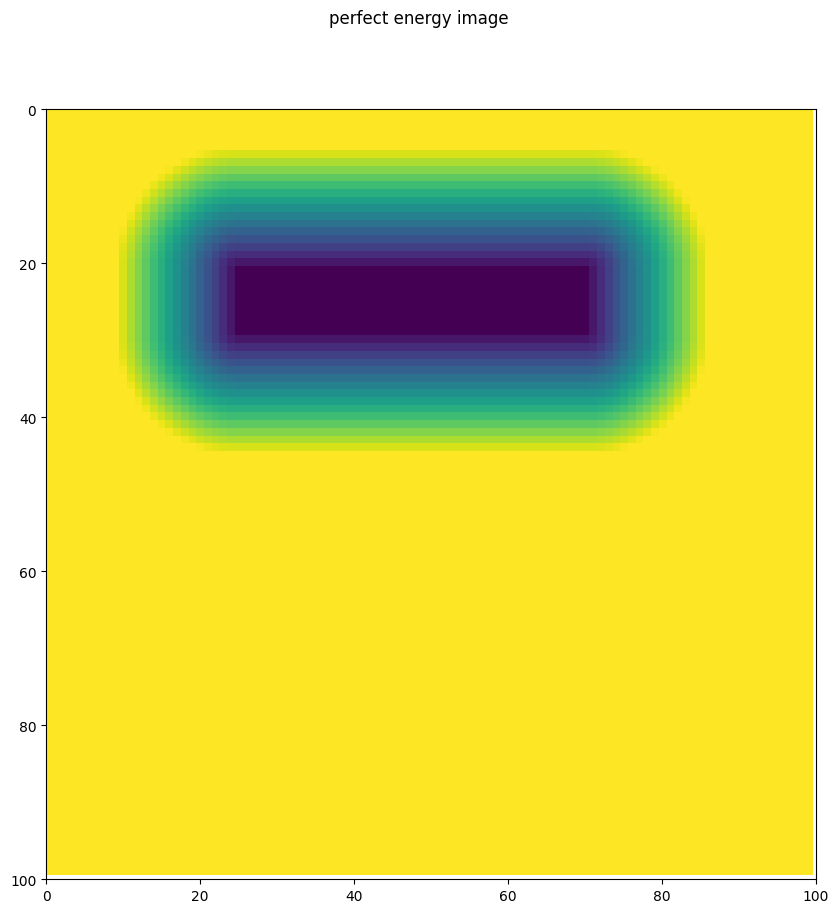

In [129]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
for i in range(25,75,5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf = s._compute_normals_complex(s.s)
dismap1N = render_distance_map_2d1F(samples_to_widths, [100, 100], norms_perf)
dismap1W = render_distance_map_2d1FW(samples_to_widths, [100, 100], norms_perf)
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1N = torch.clamp(dismap1N, max=16)
dismap1W = torch.clamp(dismap1W, max=16)

v_L_perf = (s.s - s.w / 2.0 * norms_perf).detach().cpu().numpy()
v_R_perf = (s.s + s.w / 2.0 * norms_perf).detach().cpu().numpy()

showriba(dismap1N.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)
showriba(dismap1W.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

del s

""" for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0]) """

pred=dismap1N.clone()[None,None]
predw = dismap1W.clone()[None,None]

show(dismap1N.detach().numpy(),"perfect energy image")

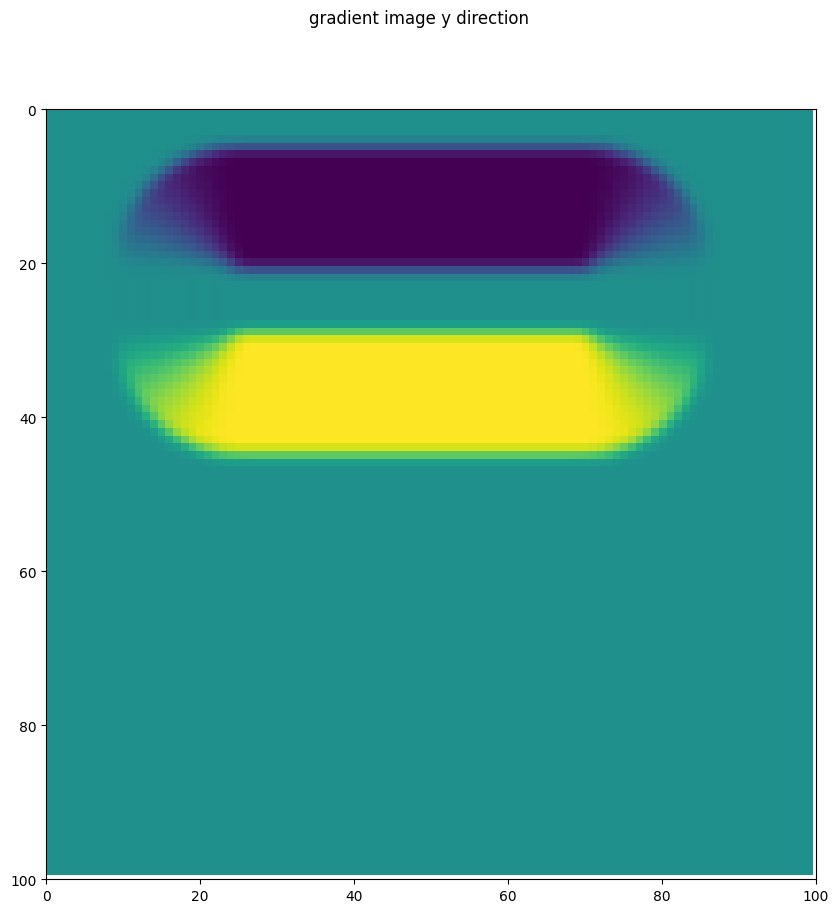

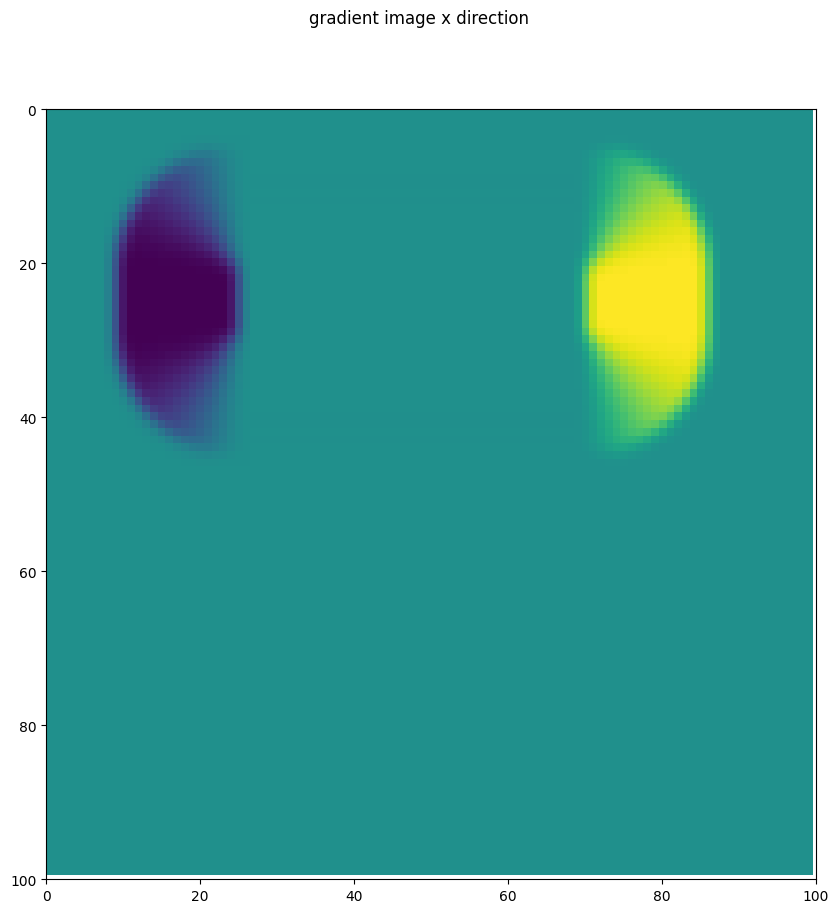

In [134]:
fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimg = cmptGradIm(pred,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)

show(gimg[0][0].detach().numpy(),"gradient image y direction")
show(gimg[0][1].detach().numpy(),"gradient image x direction")

extgradfac=1.0
gimg = gimg[0]
gimgw = gimgw[0]

croprib=[slice(0,200), slice(0,200)]

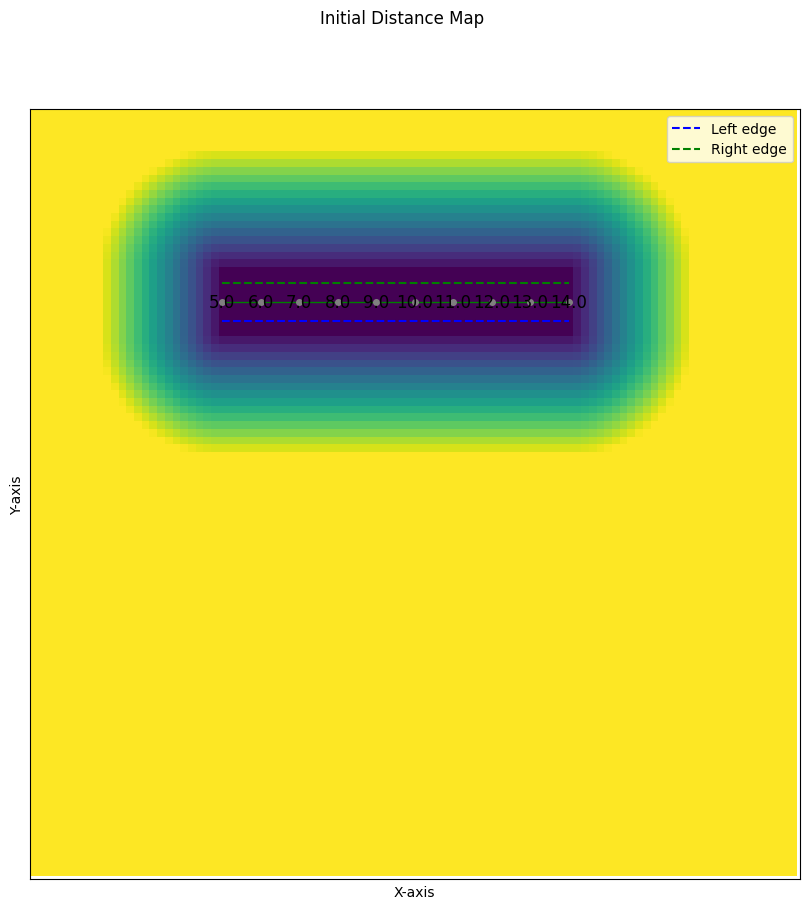

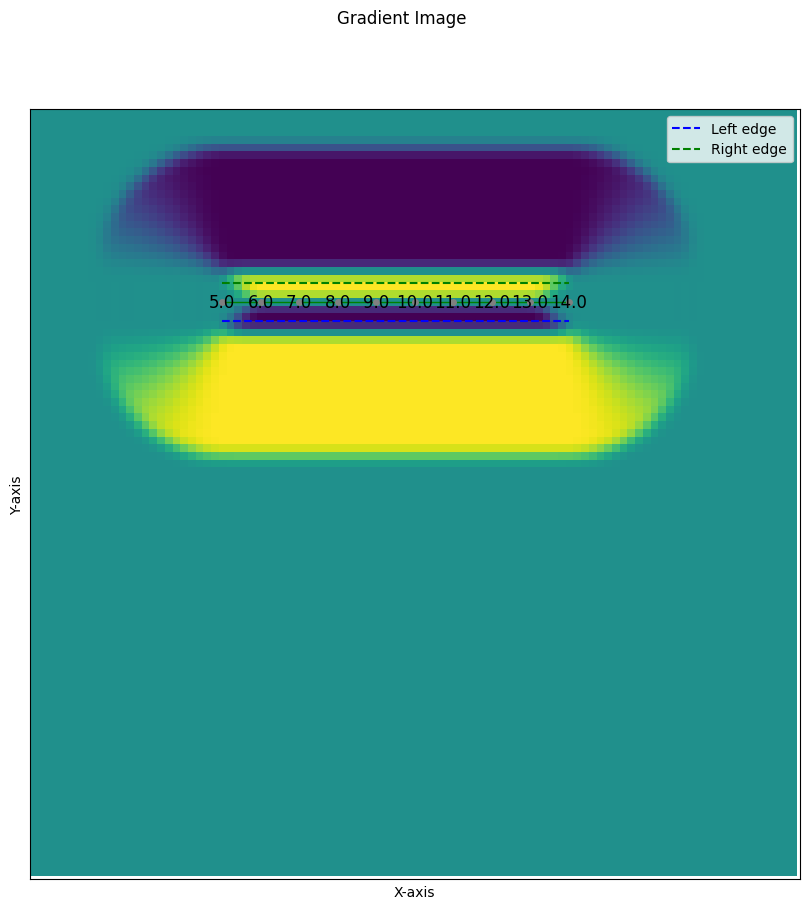

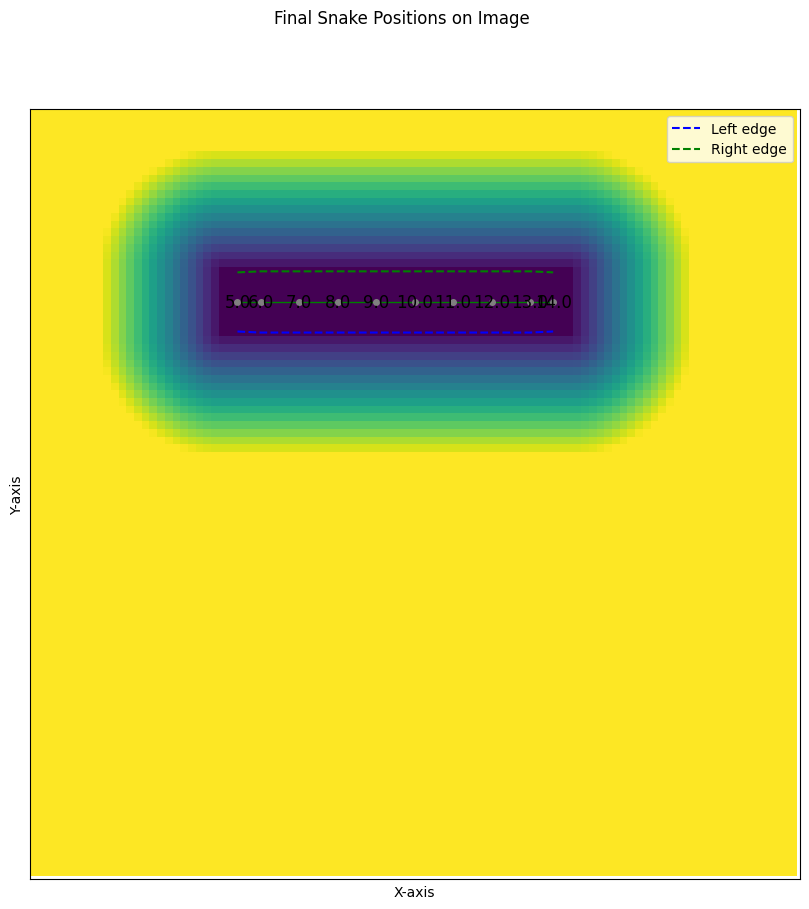

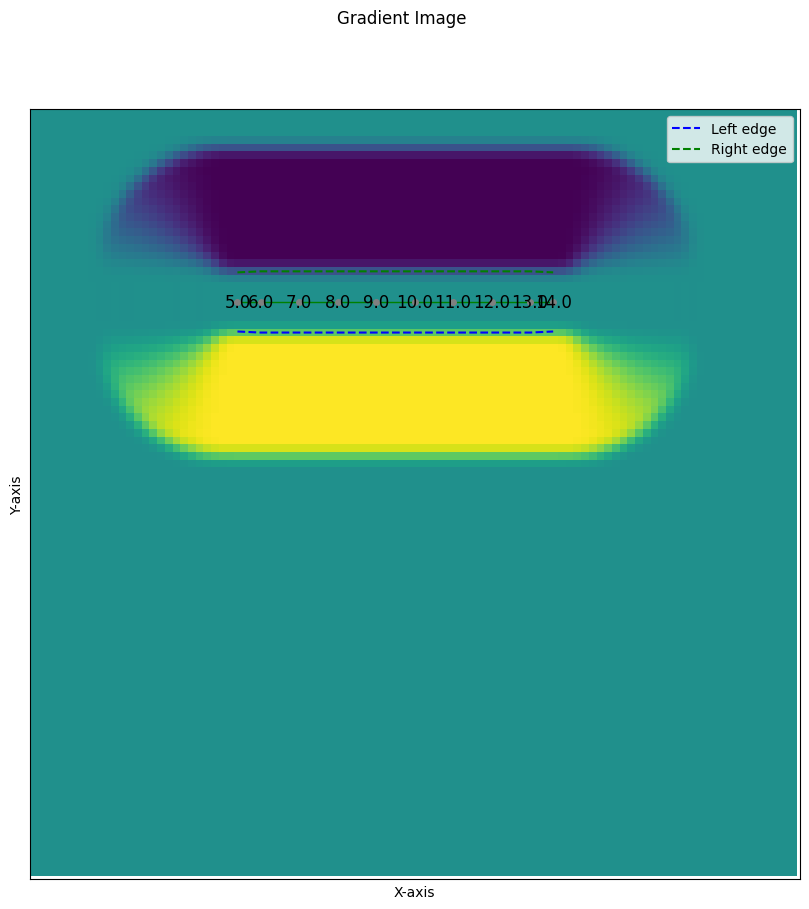

In [136]:
sa=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimgw, step_type="original")
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sa._compute_normals_complex(sa.s)
v_L_prev = (sa.s - sa.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sa.s + sa.w * norms_prev / 2).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sa.getGraph(), v_L_prev, v_R_prev)
showriba(gimgw[0].detach().cpu().numpy(), 'Gradient Image', sa.getGraph(), v_L_prev, v_R_prev)

last = sa.optim(1000)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
final_positions = sa.get_s().detach().cpu().numpy()
norms = sa._compute_normals(sa.s)
v_L = (sa.s - sa.w * norms / 2).detach().cpu().numpy()
v_R = (sa.s + sa.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sa.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image', sa.getGraph(), v_L, v_R)

# Method to display ribbon snake

In [12]:
def showriba(img, title, graph=None, v_L=None, v_R=None):   
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    
    if graph:
        pos = {n: graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray', edge_color='g', font_size=12, font_color='black')
    
    if v_L is not None and v_R is not None:
        plt.plot(v_L[:, 1], v_L[:, 0], 'b--', linewidth=1.5, label='Left edge')
        plt.plot(v_R[:, 1], v_R[:, 0], 'g--', linewidth=1.5, label='Right edge')
    
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

In [13]:
import torch as th
from Codes.Losses.renderDistanceMap import (closest_points_on_edges, closest_points_on_edges_grad, 
                         nodeEdgePosMat, getCropCoords, cropGraph_dontCutEdges)
from itertools import product

def renderRibbonDistFun_wGrad(g, nodes, n2i, crop, widths):
    """Render distance map for ribbon snake with gradient support"""
    # Generate left and right edges from centerline + width
    ne_center = nodeEdgePosMat(g, nodes, n2i)
    edges_center = th.einsum('kd,kne->ned', [nodes, ne_center])
    
    # Compute normals for the centerline
    tangent = edges_center[:, 1, :] - edges_center[:, 0, :]
    normals = th.stack([-tangent[:, 1], tangent[:, 0]], dim=1)
    norm = th.norm(normals, dim=1, keepdim=True) + 1e-8
    normals = normals / norm

    # Expand widths to match edges
    w_start = widths[n2i[edges_center[:, 0, 0].long()]]  # Get width for start nodes
    w_end = widths[n2i[edges_center[:, 1, 0].long()]]    # Get width for end nodes
    
    # Create left and right edges
    edges_left = edges_center - w_start[:, None] * normals[:, None, :]
    edges_right = edges_center + w_end[:, None] * normals[:, None, :]

    # Combine all edges (left + right boundaries)
    all_edges = th.cat([edges_left, edges_right], dim=0)

    # Get points in crop region
    pts = th.tensor(list(product(*[range(c.start, c.stop) for c in crop])), 
                   dtype=nodes.dtype, device=nodes.device)

    # Compute distances to ribbon edges
    dist, inds, diff, d, alpha = closest_points_on_edges(all_edges, pts)
    
    # Compute gradients (propagate to both centerline positions and widths)
    dist_edge_grad = closest_points_on_edges_grad(inds, diff, d, alpha)
    
    # Split gradients back to centerline and width components
    grad_center = th.zeros_like(nodes)
    grad_width = th.zeros_like(widths)
    
    # Gradient propagation logic
    for i, (u, v) in enumerate(g.edges()):
        # Gradient for centerline positions
        grad_center[n2i[u]] += dist_edge_grad[i, :, 0, :].sum(dim=0)
        grad_center[n2i[v]] += dist_edge_grad[i, :, 1, :].sum(dim=0)
        
        # Gradient for widths (derivative through edge displacement)
        grad_width[n2i[u]] += (-normals[i, 0] * dist_edge_grad[i, :, 0, 0] + 
                               -normals[i, 1] * dist_edge_grad[i, :, 0, 1]).sum()
        grad_width[n2i[v]] += (normals[i, 0] * dist_edge_grad[i, :, 1, 0] + 
                               normals[i, 1] * dist_edge_grad[i, :, 1, 1]).sum()

    dist = dist.reshape([c.stop - c.start for c in crop])
    return dist, (grad_center, grad_width)

def renderRibbonDistBig(gr, nodes, n2i, widths, size, cropsz, dmax, maxedgelen=None):
    """Full ribbon distance map renderer with width support"""
    dist = th.zeros(tuple(size), dtype=nodes.dtype, device=nodes.device)
    grad_center = th.zeros_like(nodes)
    grad_width = th.zeros_like(widths)

    margin = dmax if maxedgelen is None else (dmax + 0.5*maxedgelen)/1.414
    gcropinds = getCropCoords(size, cropsz, margin)
    gcrops = [cropGraph_dontCutEdges(gr, ci) for ci in gcropinds]
    dcropinds = getCropCoords(size, cropsz, 0)

    for g, di in zip(gcrops, dcropinds):
        if len(g.nodes) == 0:
            dist[di] = dmax
        else:
            crop_dist, (crop_grad_c, crop_grad_w) = renderRibbonDistFun_wGrad(g, nodes, n2i, di, widths)
            dist[di] = crop_dist.clamp(max=dmax)
            grad_center += crop_grad_c
            grad_width += crop_grad_w

    return dist.clamp(max=dmax), (grad_center, grad_width)

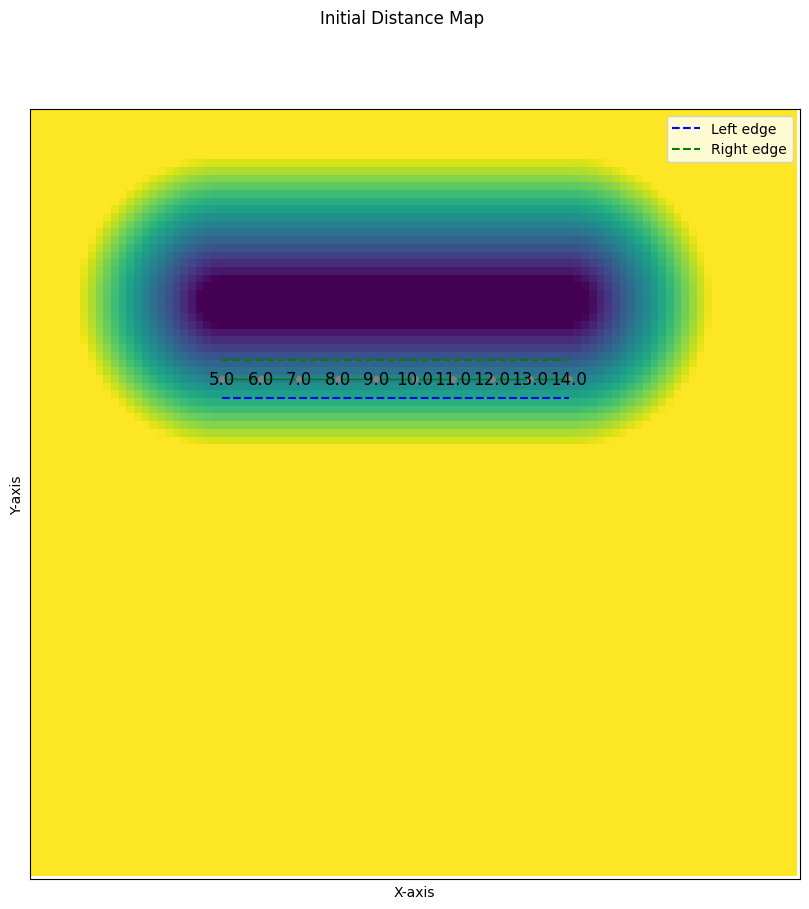

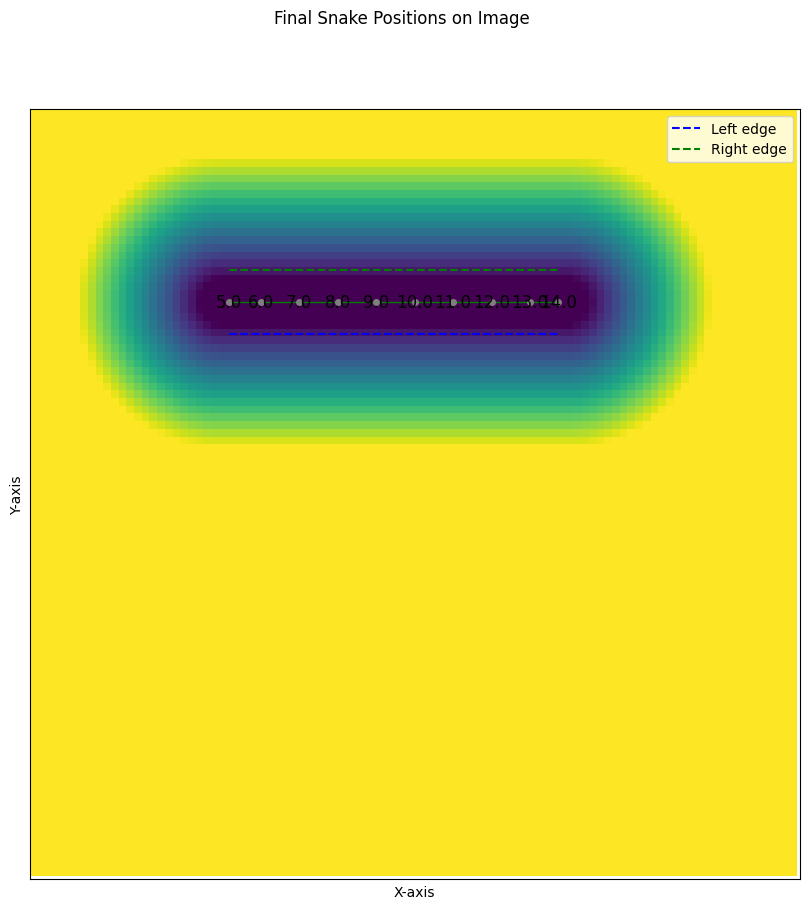

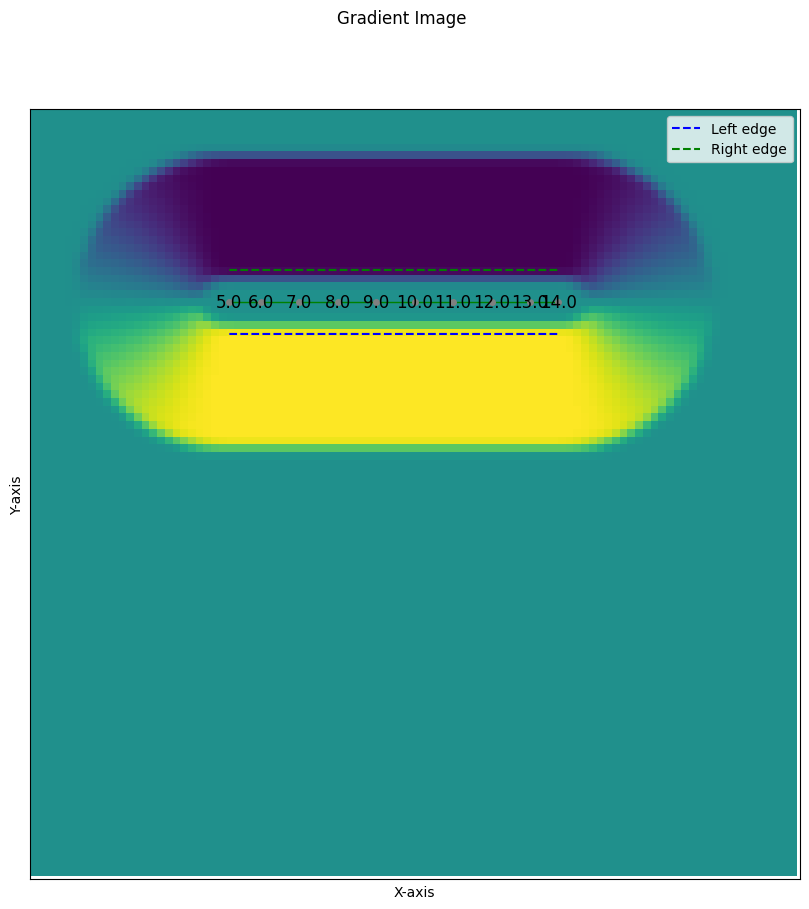

In [14]:
sa=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, step_type="stiff")
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sa._compute_normals_complex(sa.s)
v_L_prev = (sa.s - sa.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sa.s + sa.w * norms_prev / 2).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sa.getGraph(), v_L_prev, v_R_prev)

last = sa.optim(400)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
final_positions = sa.get_s().detach().cpu().numpy()
norms = sa._compute_normals(sa.s)
v_L = (sa.s - sa.w * norms).detach().cpu().numpy()
v_R = (sa.s + sa.w * norms).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sa.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image', sa.getGraph(), v_L, v_R)

# Normal Distance Map (HAS AN ERROR, CREATES POLYGON IN THE MIDDLE ALL THE TIME)

In [15]:
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1(samples_with_widths, size, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    
    # 1. Compute normals and generate left/right points
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    n_points = len(centers)
    
    # Compute tangents and normals
    tangents = np.zeros_like(centers)
    if n_points > 1:
        tangents[0] = centers[1] - centers[0]
        tangents[-1] = centers[-1] - centers[-2]
        if n_points > 2:
            tangents[1:-1] = centers[2:] - centers[:-2]
    
    normals = np.stack([-tangents[:, 1], tangents[:, 0]], axis=1)
    norms = np.linalg.norm(normals, axis=1, keepdims=True) + 1e-8
    normals = normals / norms
    
    # 2. Generate polygon outline
    left_pts = centers - normals * widths[:, None]/2
    right_pts = centers + normals * widths[:, None]/2
    
    # Create polygon: left edge + reversed right edge
    polygon = np.vstack([left_pts, right_pts[::-1]])
    
    # 3. Create matplotlib Path for inside/outside checks
    path = Path(polygon)
    
    # 4. Compute distance to polygon edges
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Check inside/outside
    is_inside = path.contains_points(grid_points).reshape(h, w).T
    
    # For outside points, compute distance to edges
    for i in range(n_points-1):
        # Get edge between consecutive left points
        p1 = left_pts[i]
        p2 = left_pts[i+1]
        dist_map = np.minimum(dist_map, _distance_to_segment(grid_points, p1, p2).reshape(h, w).T)
        
        # Get edge between consecutive right points
        p1 = right_pts[i]
        p2 = right_pts[i+1]
        dist_map = np.minimum(dist_map, _distance_to_segment(grid_points, p1, p2).reshape(h, w).T)
    
    # Close the polygon
    p1, p2 = left_pts[-1], right_pts[0]
    dist_map = np.minimum(dist_map, _distance_to_segment(grid_points, p1, p2).reshape(h, w).T)
    
    # Set inside points to 0
    dist_map[is_inside] = 0.0
    
    # Convert to torch
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segment(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment"""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len**2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# Fixed Version

In [16]:
# Python
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1F(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # 1. Compute tangents and normals based on centers
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    normals = np.array(normals)

    # 2. Generate left and right polygon edges
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # Build the polygon that represents the ribbon outline.
    # Here we combine left_pts and right_pts (reversed) to 
    # get a closed polygon without an extra segment.
    polygon = np.vstack([left_pts, right_pts[::-1]])

    # 3. Create a matplotlib Path for inside/outside checks with the computed polygon.
    path = Path(polygon)

    # 4. Compute grid points for the output distance map.
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # 5. Compute distance for each edge in the polygon.
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # ensures closure
        seg_dist = _distance_to_segmentF(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Set inside (ribbon) points to 0.
    dist_map[is_inside] = 0.0

    # Convert the numpy array to a torch tensor.
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segmentF(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# Distance Map W version

In [17]:
# Python
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1FW(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # 1. Compute tangents and normals based on centers
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    normals = np.array(normals)

    # 2. Generate left and right polygon edges
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # Build the polygon that represents the ribbon outline.
    # Here we combine left_pts and right_pts (reversed) to 
    # get a closed polygon without an extra segment.
    polygon = np.vstack([left_pts, right_pts[::-1]])

    # 3. Create a matplotlib Path for inside/outside checks with the computed polygon.
    path = Path(polygon)

    # 4. Compute grid points for the output distance map.
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # 5. Compute distance for each edge in the polygon.
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # ensures closure
        seg_dist = _distance_to_segmentFW(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Convert the numpy array to a torch tensor.
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segmentFW(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

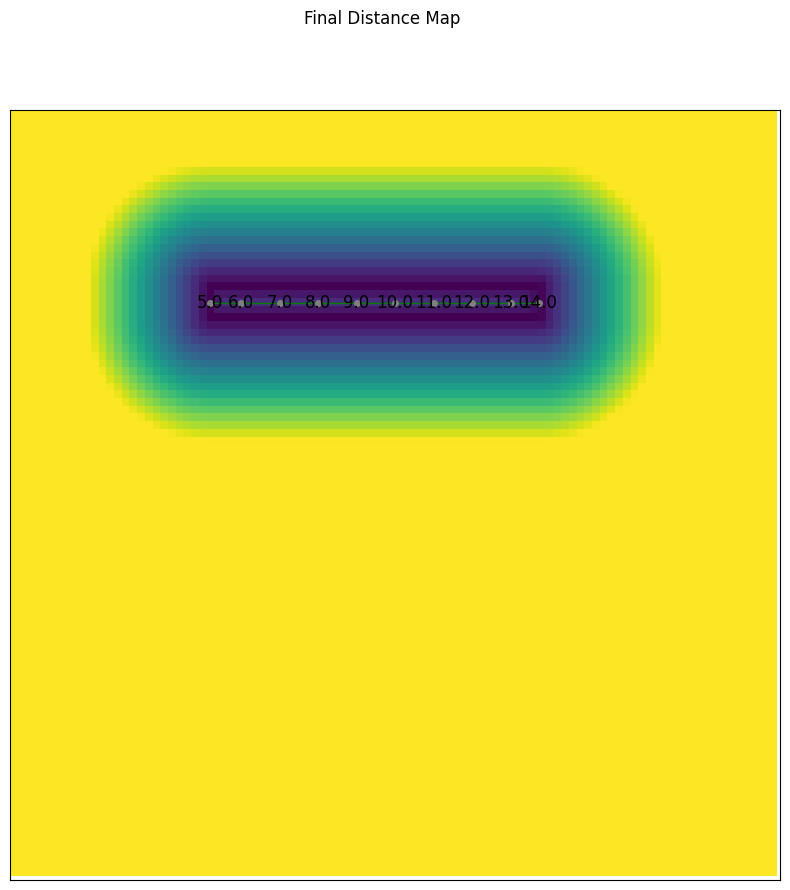

In [19]:
gra = sa.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = sa.w.numpy().flatten()
samples_to_widths = list(zip(nodes, widths))
norms = sa._compute_normals_complex(sa.s).detach().cpu().numpy()

dismap1 = render_distance_map_2d1FW(samples_to_widths, [100, 100], norms)
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1 = torch.clamp(dismap1, max=16)
show(dismap1.detach().cpu().numpy(), 'Final Distance Map', gra)

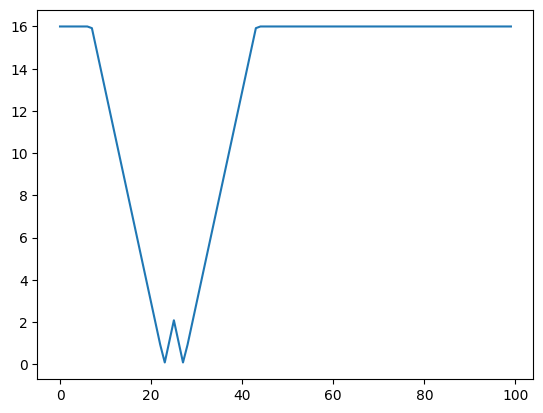

In [20]:
plt.plot(dismap1.numpy()[:, 50])

C:\Users\serta\AppData\Local\Temp\ipykernel_17924\4287794838.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))


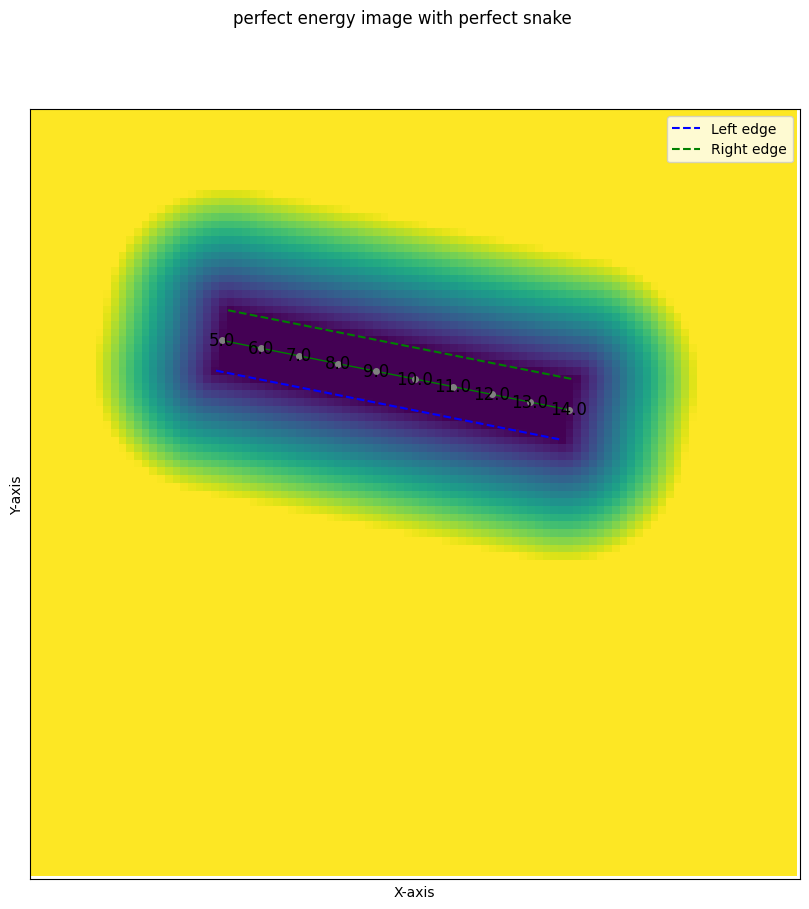

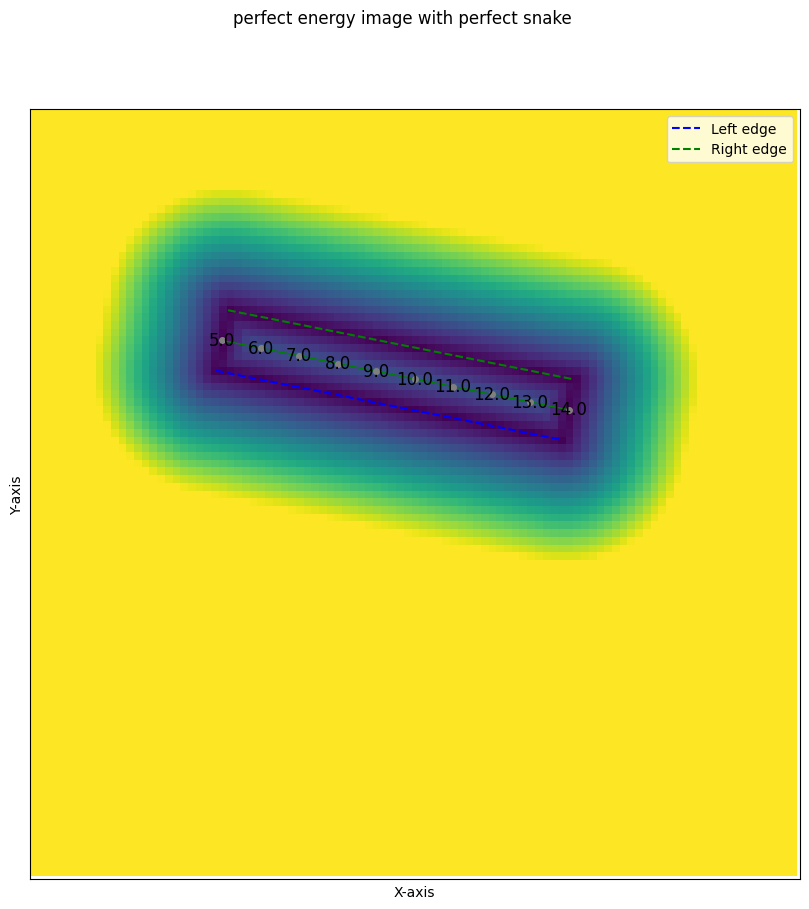

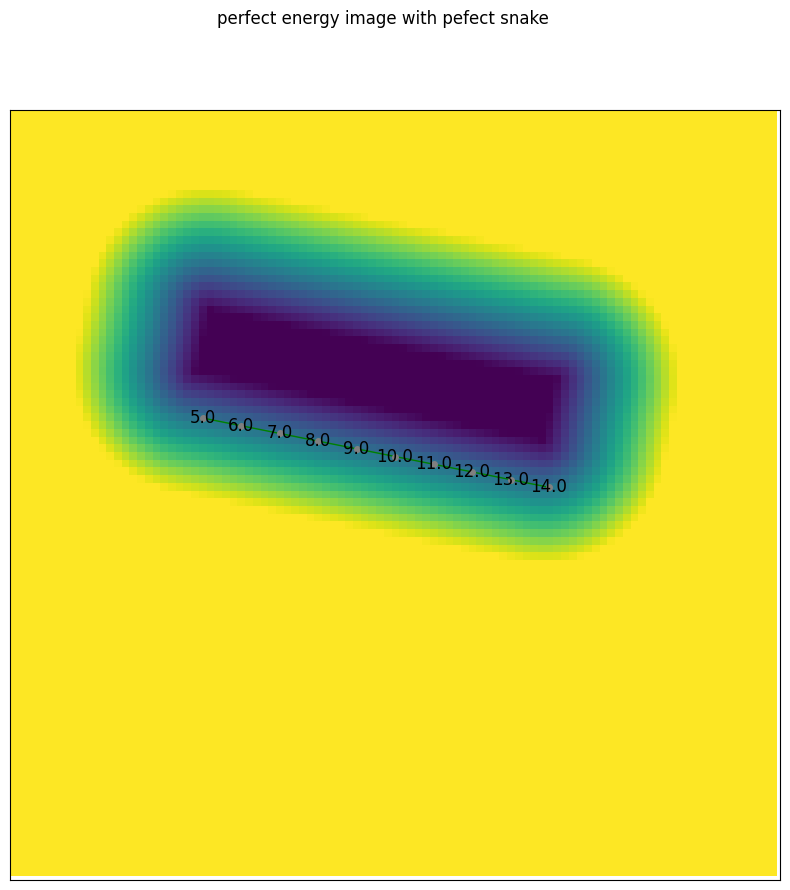

In [143]:
g = nx.Graph()
widths = th.tensor([8.0]*10,dtype=th.float32)
for i in range(25,75,5):  # Start from 0
    g.add_node(i/5, pos=np.array([25 + i/5, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf = s._compute_normals_complex(s.s)
dismap1N = render_distance_map_2d1F(samples_to_widths, [100, 100], norms_perf)
dismap1W = render_distance_map_2d1FW(samples_to_widths, [100, 100], norms_perf)
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1N = torch.clamp(dismap1N, max=16)
dismap1W = torch.clamp(dismap1W, max=16)

v_L_perf = (s.s - s.w / 2.0 * norms_perf).detach().cpu().numpy()
v_R_perf = (s.s + s.w / 2.0 * norms_perf).detach().cpu().numpy()

showriba(dismap1N.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)
showriba(dismap1W.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

del s

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0])

predN=dismap1N.clone()[None,None]
predW=dismap1W.clone()[None,None]

show(dismap1N.detach().numpy(),"perfect energy image with pefect snake", g)

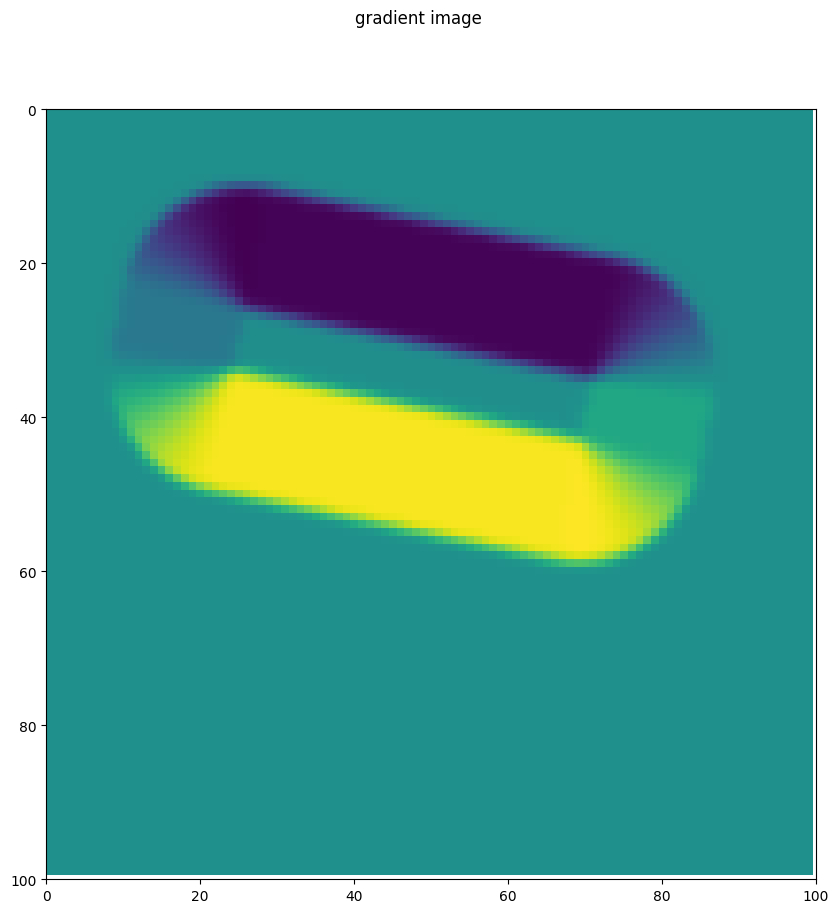

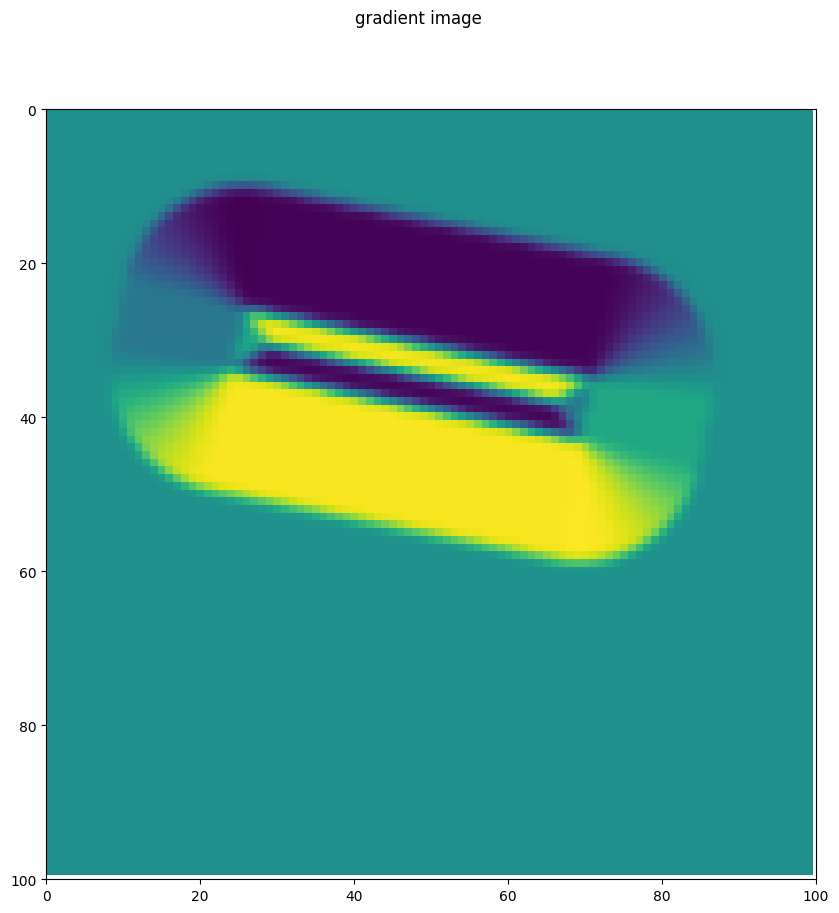

In [144]:
fltr = makeGaussEdgeFltr(0.75,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimgN = cmptGradIm(predN,fltrtr)
gimgW = cmptGradIm(predW,fltrtr)

show(gimgN[0][0].detach().numpy(),"gradient image")
show(gimgW[0][0].detach().numpy(),"gradient image")

extgradfac=1.0
gimgN = gimgN[0]
gimgW = gimgW[0]

croprib=[slice(0,200), slice(0,200)]

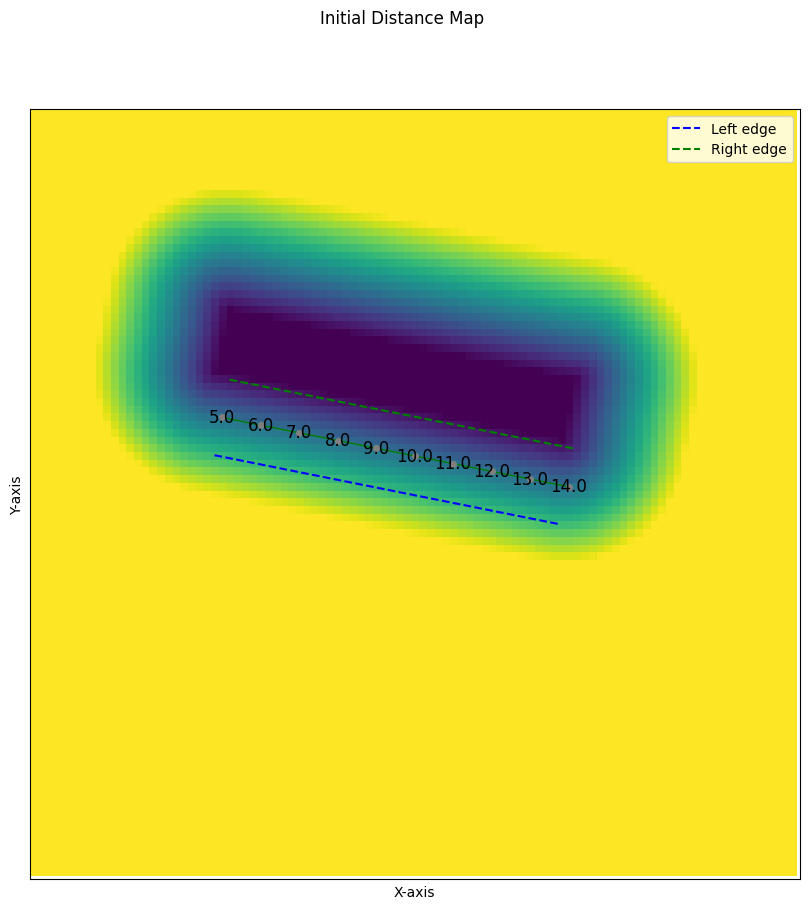

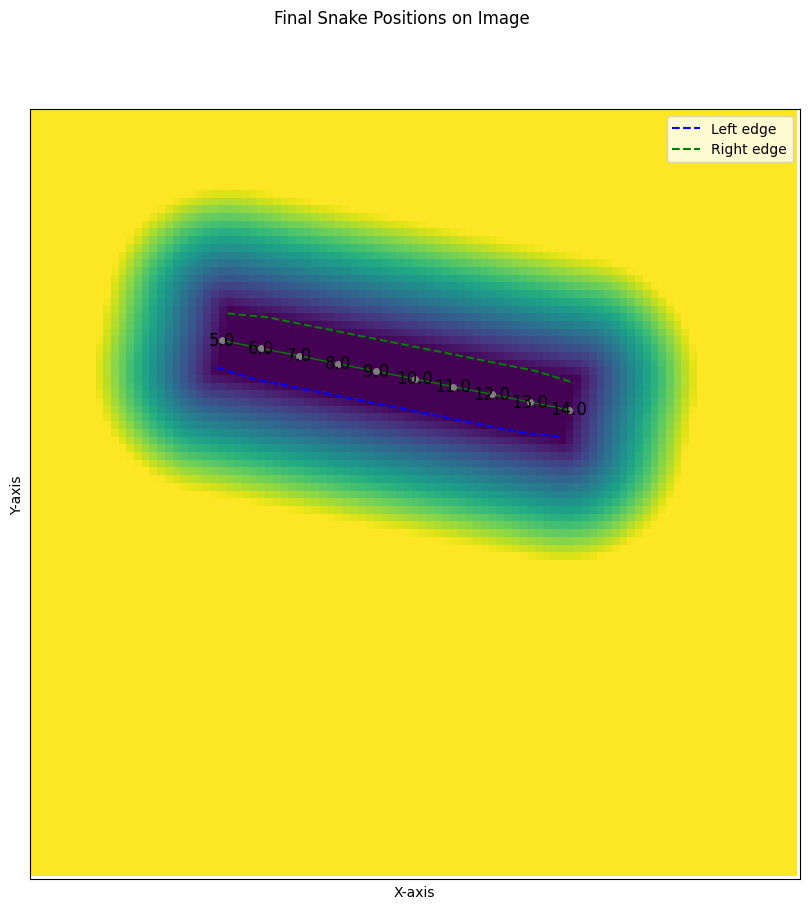

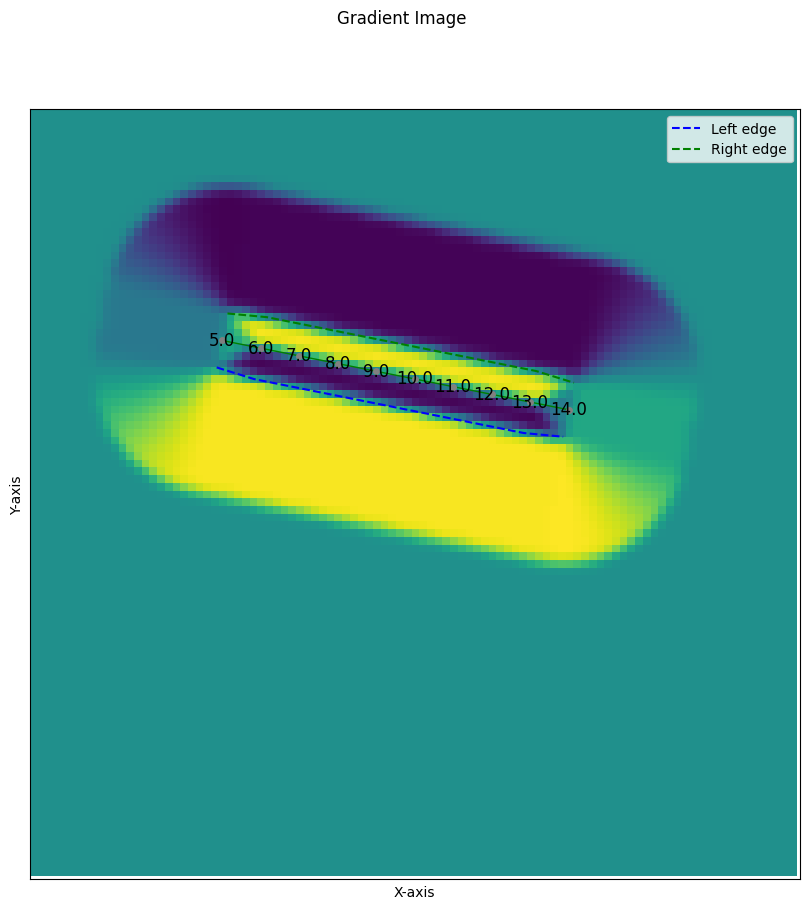

In [145]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimgN, gimgW=gimgW,step_type="stiff")
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w * norms_prev / 2).detach().cpu().numpy()
showriba(predN[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(1000)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms / 2).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(predN[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimgW[0].detach().cpu().numpy(), 'Gradient Image', sb.getGraph(), v_L, v_R)

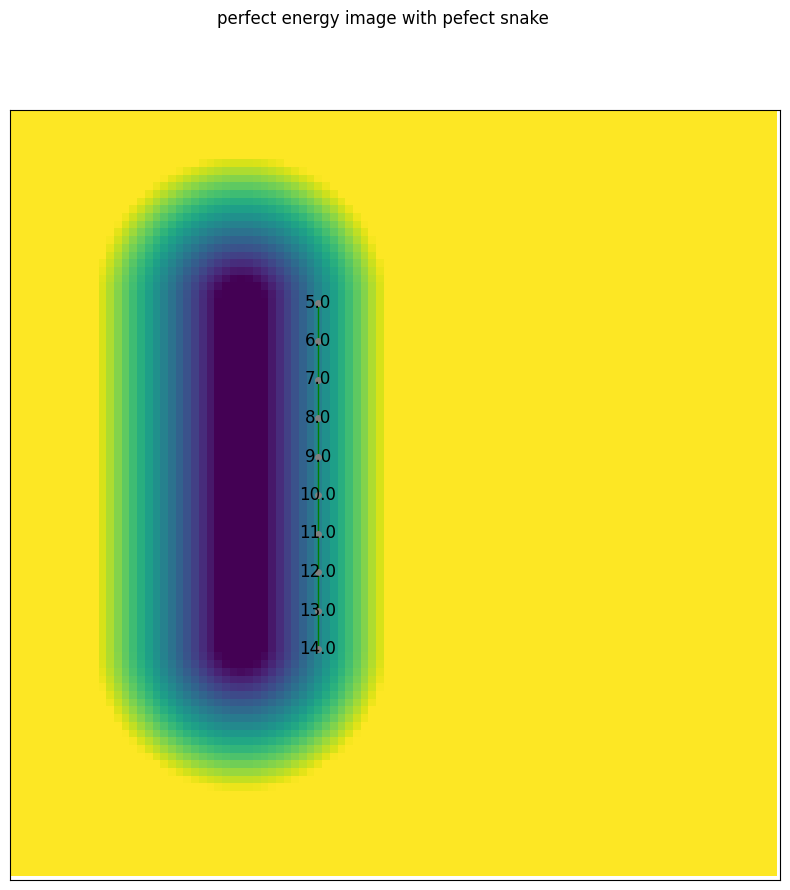

In [146]:
g = nx.Graph()
for i in range(25,75,5):  # Start from 0
    g.add_node(i/5, pos=np.array([i, 30]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz=0.33
alpha=0
beta=0
crop=[slice(0,200), slice(0,200)]
ndims=2

s=Ribbon_Snake(g,crop,stepsz,alpha,beta,ndims)
a = s.get_samples_with_widths()
widths = np.array([width for _, width in a])
widths = widths * 5 + 1
s.set_widths(widths)

size=[100,100]
cropsz=[16,16]
dmax=16
maxedge=4 
pred_perfect=s.render_distance_map(size, cropsz, dmax, maxedge)

#pred_perfect = s.renderDist(size,cropsz,dmax, maxedge)

del s

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,10])

pred_initial=pred_perfect.clone()[None,None]
pred = pred_initial.clone()

show(pred_perfect.detach().numpy(),"perfect energy image with pefect snake", g)

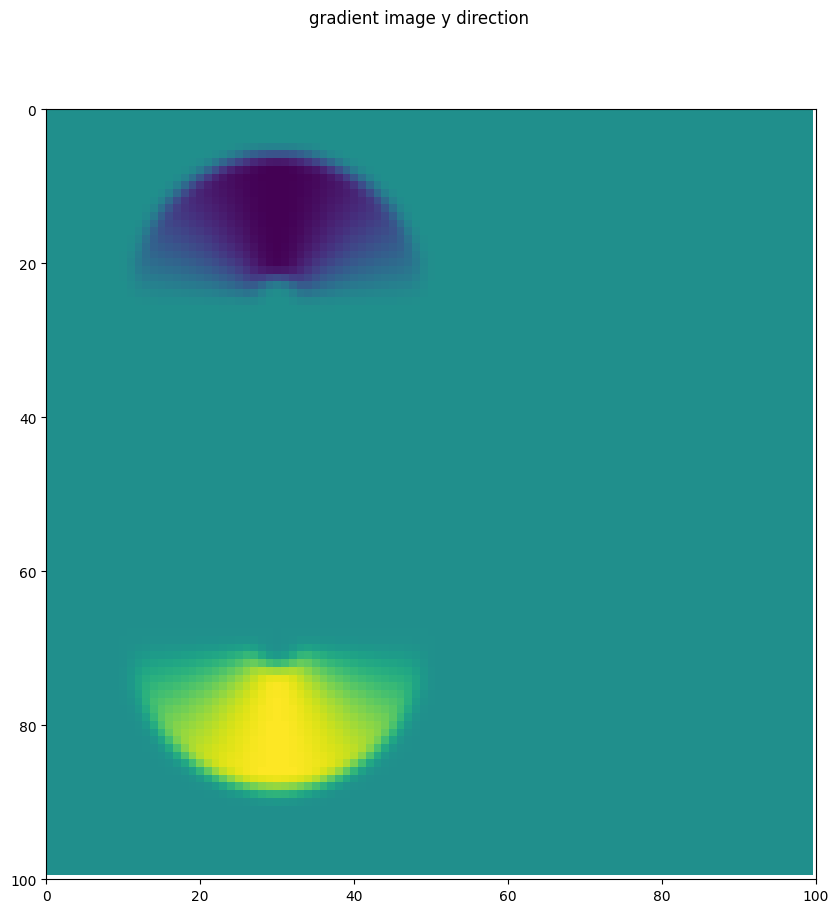

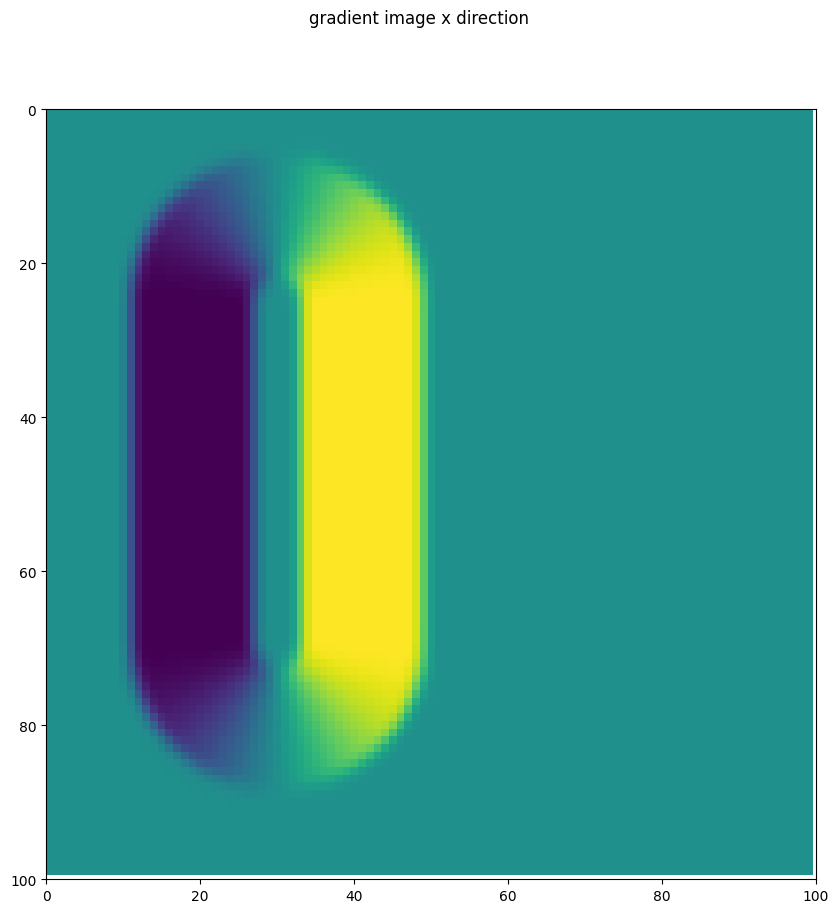

In [151]:
fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimg = cmptGradIm(pred,fltrtr)

show(gimg[0][0].detach().numpy(),"gradient image y direction")
show(gimg[0][1].detach().numpy(),"gradient image x direction")

extgradfac=1.0
gimg = gimg[0]

croprib=[slice(0,200), slice(0,200)]

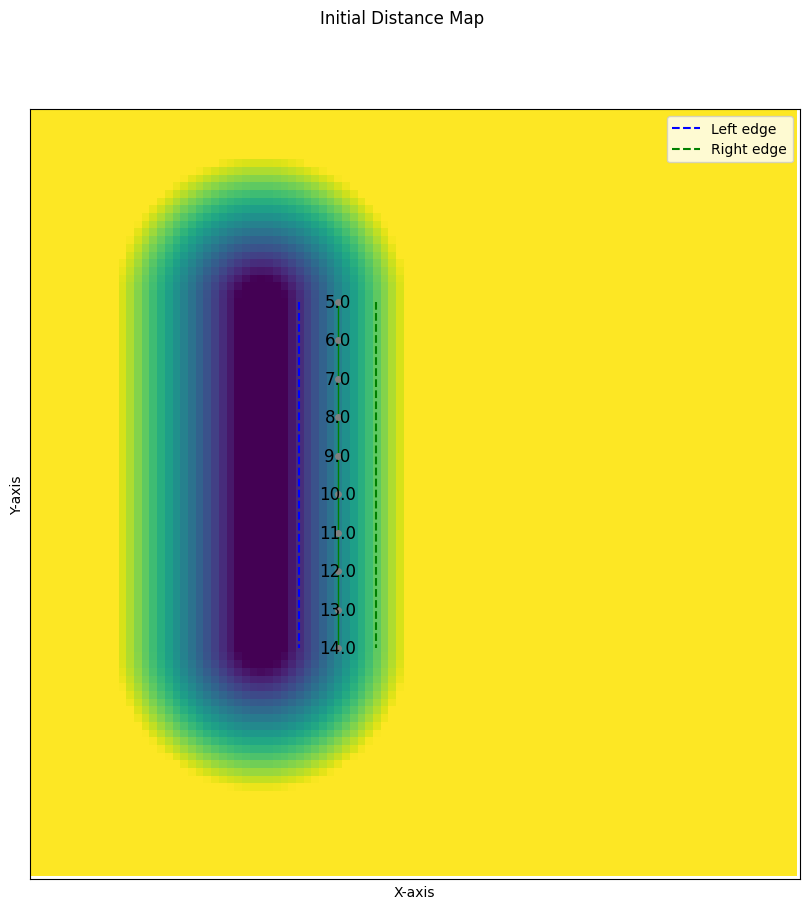

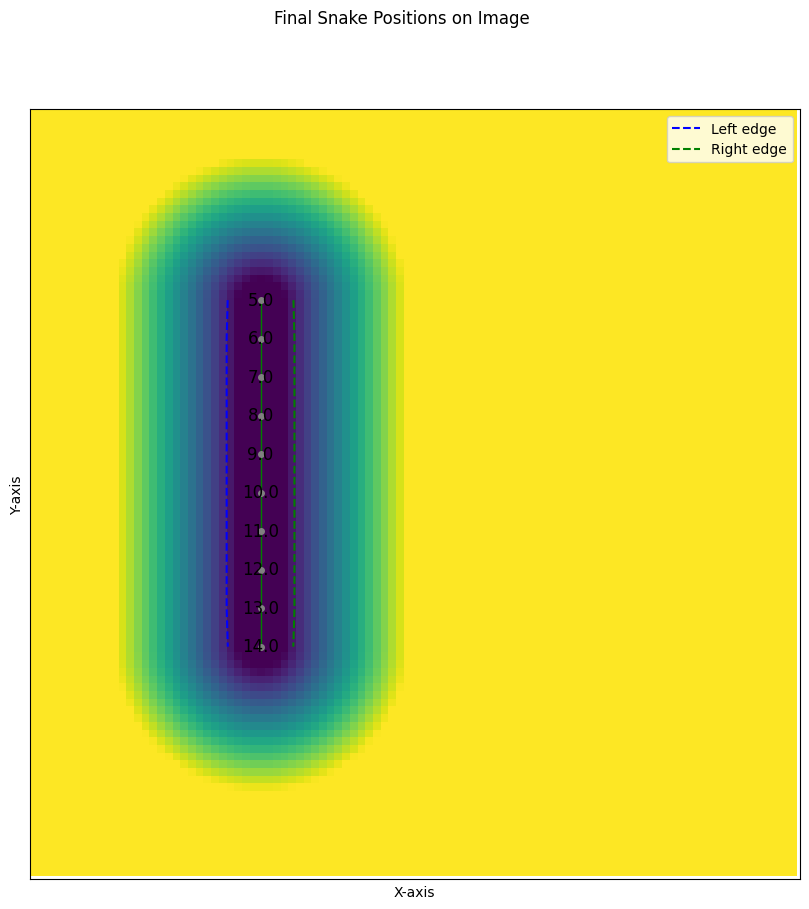

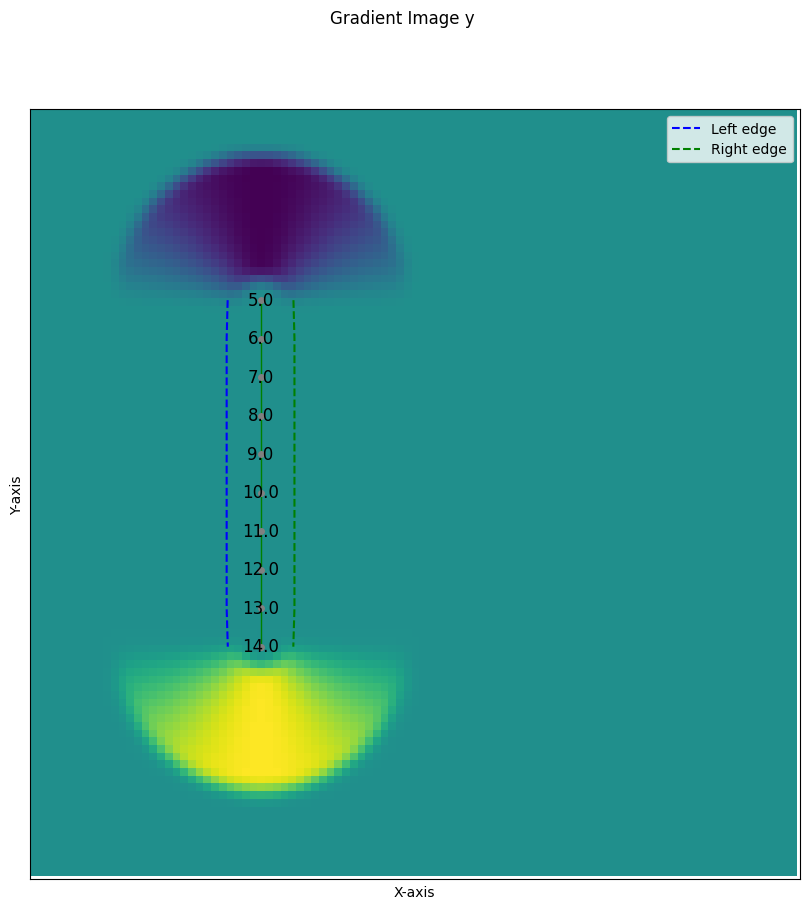

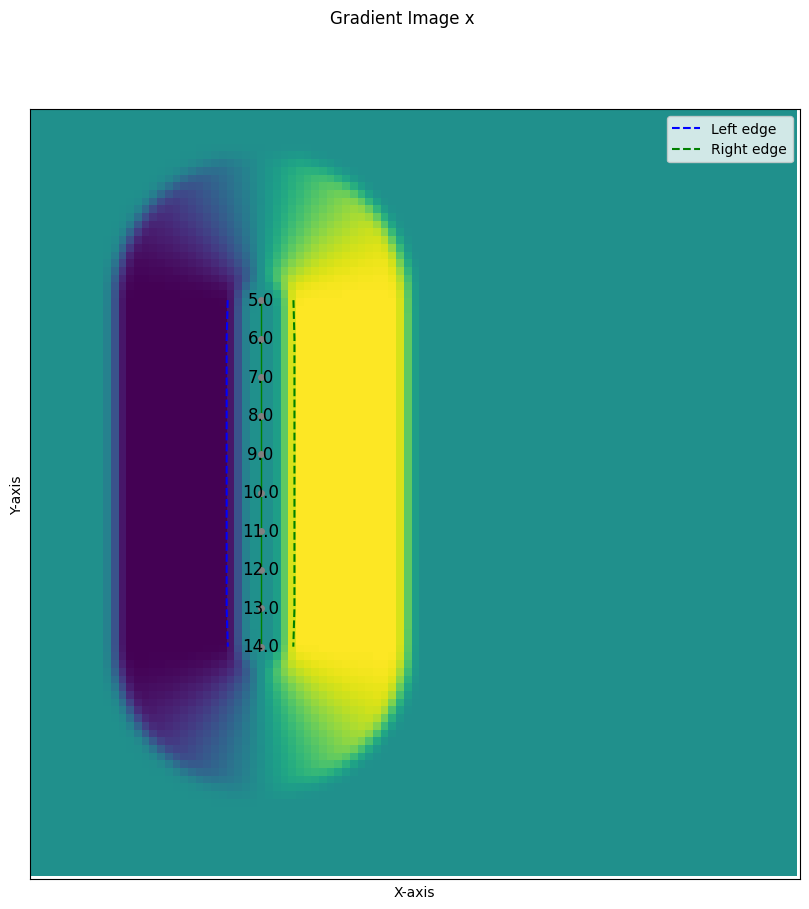

In [152]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimg,step_type="stiff")
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w * norms_prev / 2).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(1000)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image y', sb.getGraph(), v_L, v_R)
showriba(gimg[1].detach().cpu().numpy(), 'Gradient Image x', sb.getGraph(), v_L, v_R)

# SNAKE EXAMPLES WITH DIFFERENT WIDTHS AND DIFFERENT LOCATIONS

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


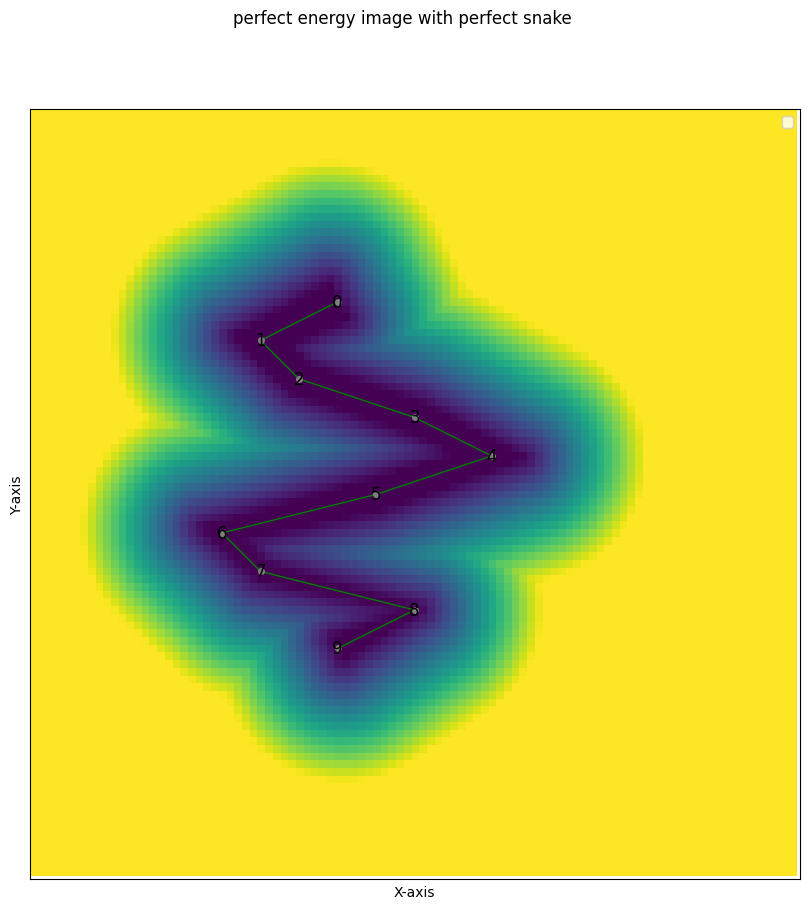

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


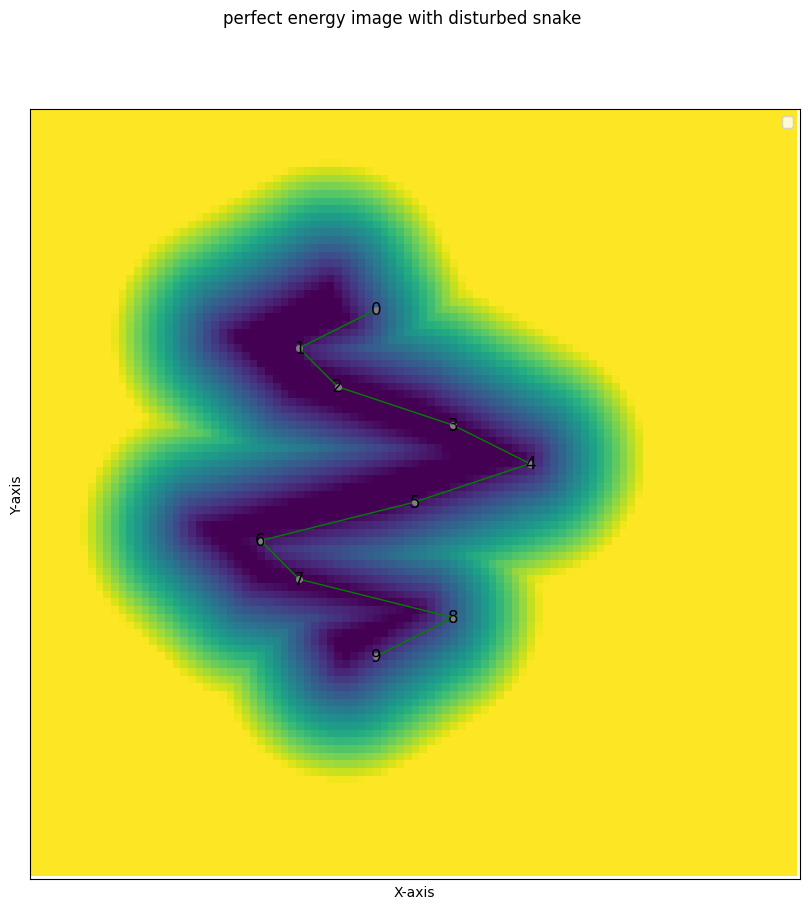

In [153]:
g = nx.Graph()
node_positions = [
    (25, 40), (30, 30), (35, 35), (40, 50), (45, 60), 
    (50, 45), (55, 25), (60, 30), (65, 50), (70, 40)
]
widths = [5, 7, 4, 4, 8, 4, 5, 2, 1, 3]

for i, pos in enumerate(node_positions):
    g.add_node(i, pos=np.array(pos))
    if i > 0:
        g.add_edge(i, i - 1)

stepsz = 0.33
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(np.array(widths))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

dismap1 = render_distance_map_2d1F(samples_to_widths, [100, 100], s._compute_normals_complex(s.s))
dismap1W = render_distance_map_2d1FW(samples_to_widths, [100, 100], s._compute_normals_complex(s.s))
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1 = torch.clamp(dismap1, max=16)
dismap1W = torch.clamp(dismap1W, max=16)
showriba(dismap1.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

#del s

""" disturbances = [
    (0, 5), (0, -3), (0, 7), (0, 0), (0, 6), 
    (0, 1), (0, 7), (0, 2), (0, -5), (0, 1)
]

for i, pos in enumerate(disturbances):
    g.nodes[i]["pos"] += np.array(pos) """

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([1,5])

pred = dismap1.clone()[None, None]
predW = dismap1W.clone()[None, None]

showriba(pred[0,0].detach().numpy(), "perfect energy image with disturbed snake", g)

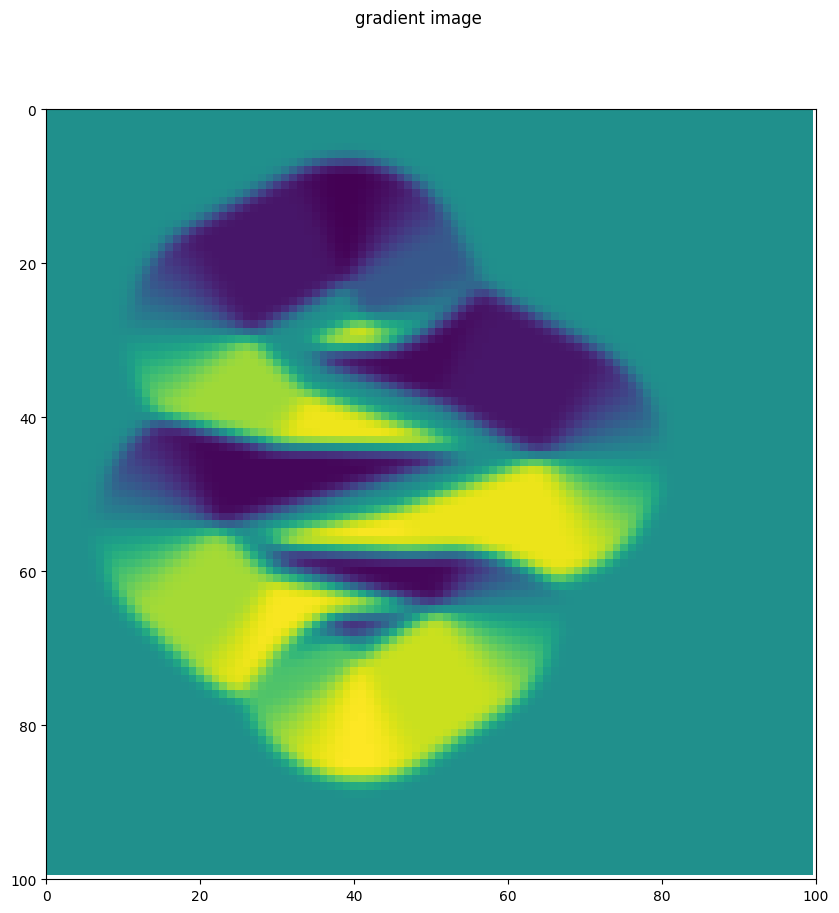

In [154]:
fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimg = cmptGradIm(pred,fltrtr)
gimgW = cmptGradIm(predW,fltrtr)
show(gimg[0][0].detach().numpy(),"gradient image")

extgradfac=1.0
gimg = gimg[0]
gimgW = gimgW[0]
croprib=[slice(0,200), slice(0,200)]

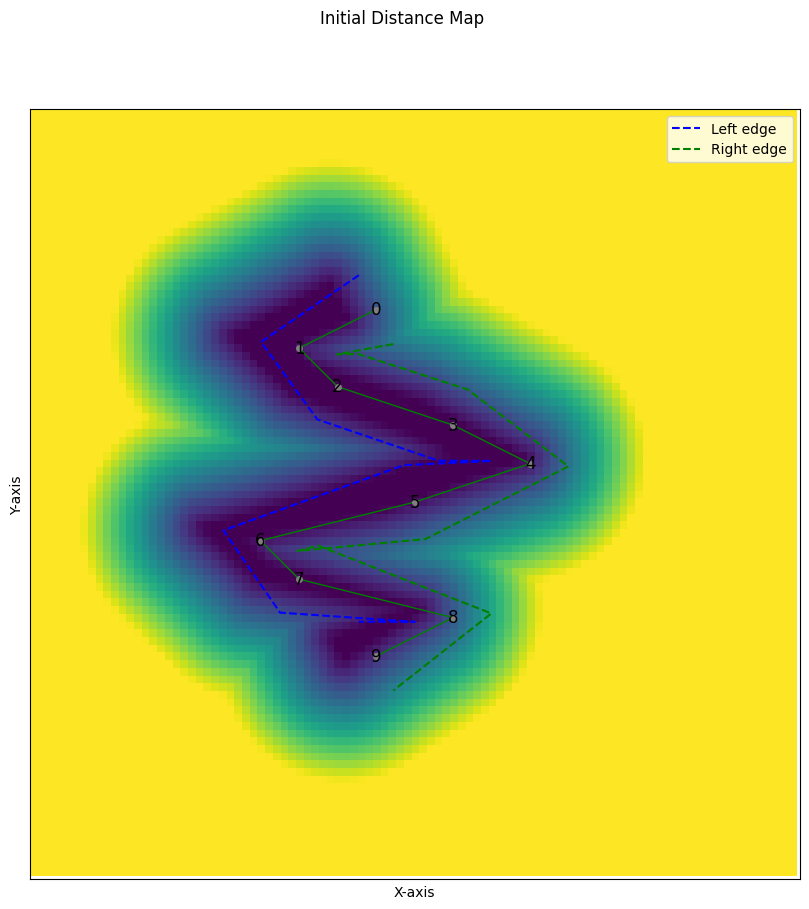

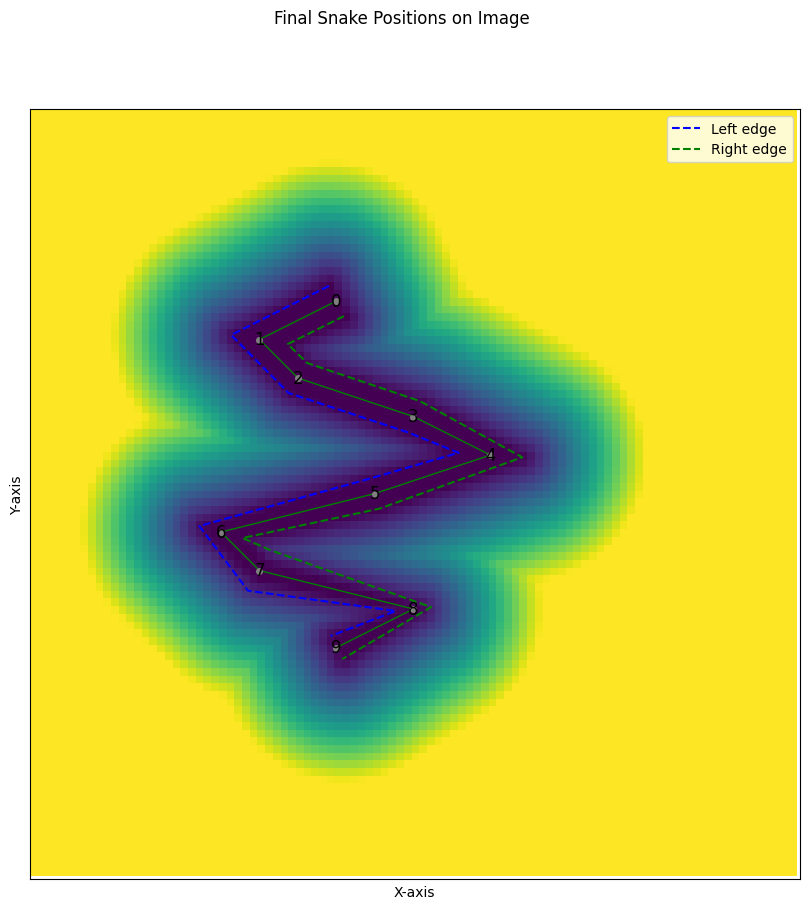

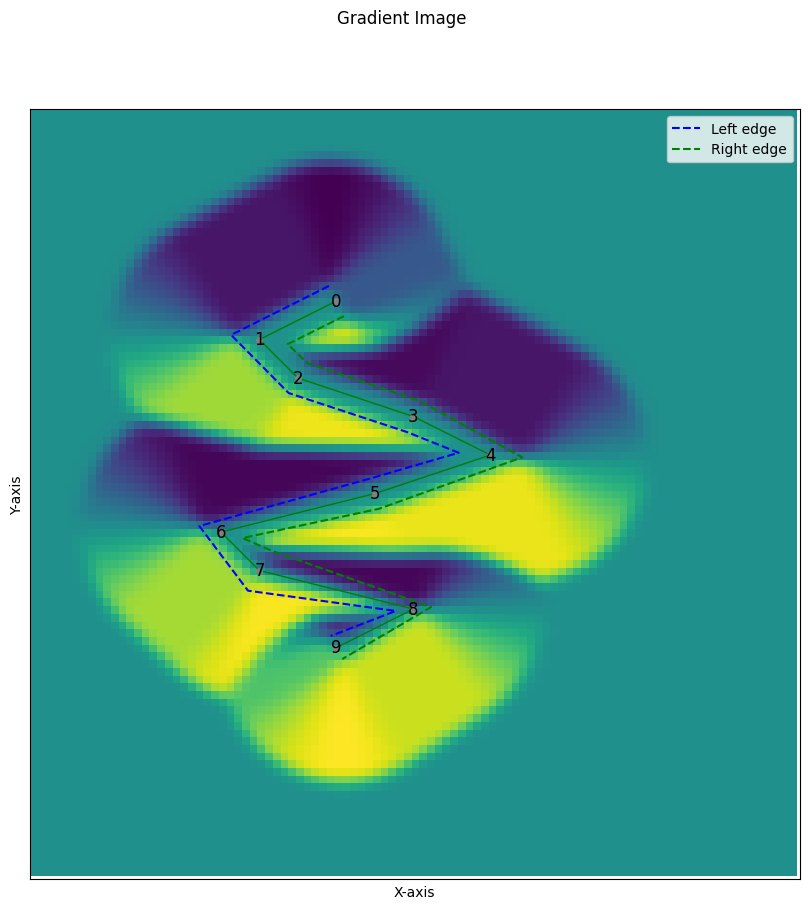

In [155]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimgW, step_type="stiff")
#sb.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w * norms_prev / 2).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(1000)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms / 2).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image', sb.getGraph(), v_L, v_R)

# Sinusoid Example

In [101]:
from math import sin,pi

C:\Users\serta\AppData\Local\Temp\ipykernel_17924\1909931747.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))


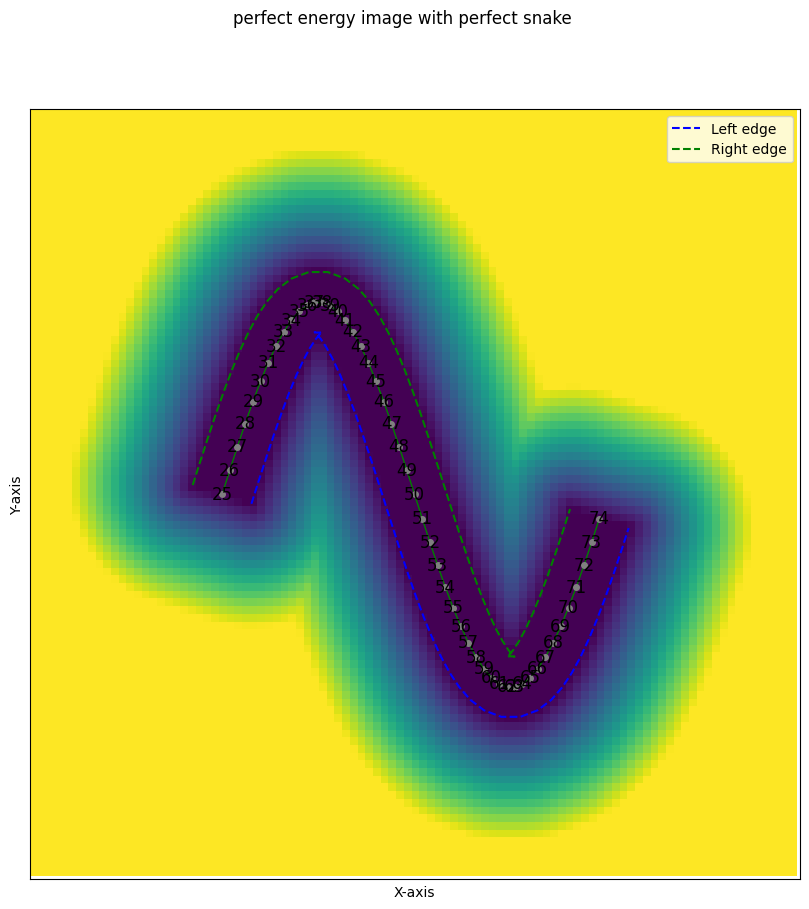

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


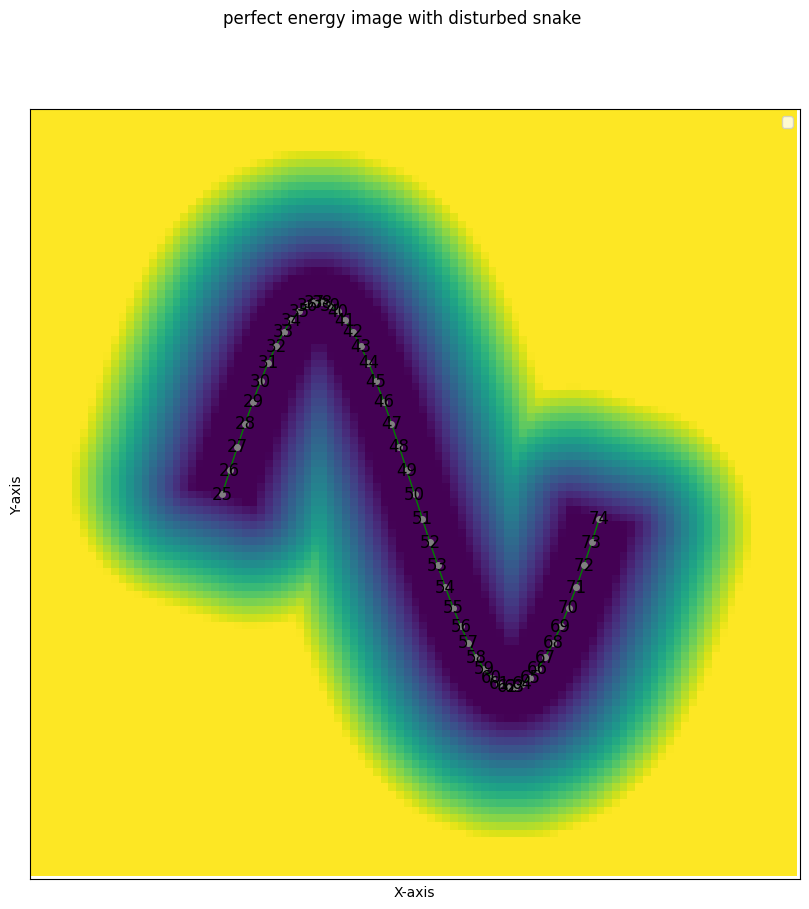

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


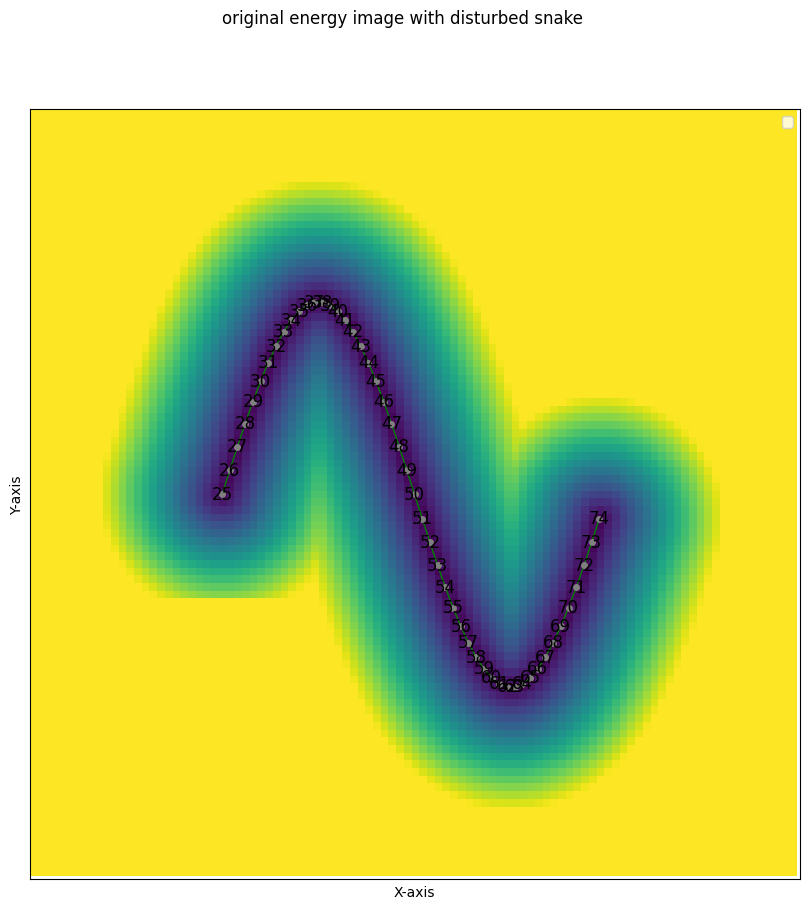

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


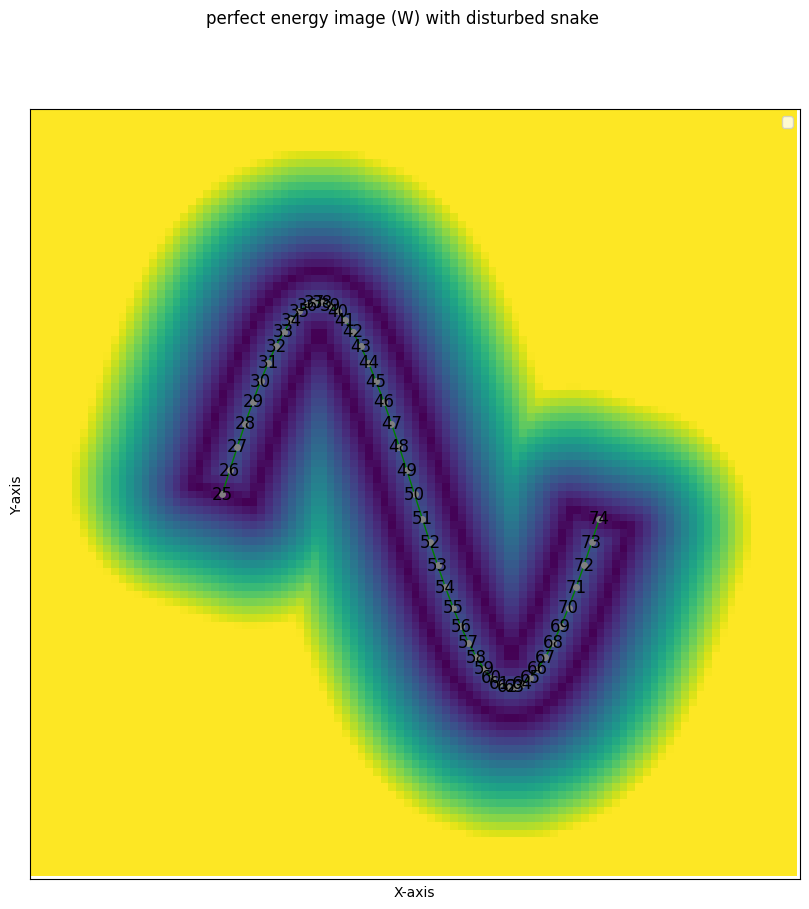

In [156]:
g=nx.Graph()
widths = th.tensor([8.0]*50,dtype=th.float32)
for i in range(25,75):
    g.add_node(i,pos=np.array([sin(i*2*pi/50.0)*25+50,i]))
    if i>25:
        g.add_edge(i,i-1)

stepsz = 0.33
alpha = 0
beta = 0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf = s._compute_normals_complex(s.s)
dismap1 = render_distance_map_2d1F(samples_to_widths, [100, 100], norms_perf)
dismap_w = render_distance_map_2d1FW(samples_to_widths, [100, 100], norms_perf)
dismap_original = s.renderDistanceMap([100, 100], [16, 16], 16, 4)
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1 = torch.clamp(dismap1, max=16)
dismap_w = torch.clamp(dismap_w, max=16)

v_L_perf = (s.s - s.w / 2.0 * norms_perf).detach().cpu().numpy()
v_R_perf = (s.s + s.w / 2.0 * norms_perf).detach().cpu().numpy()

showriba(dismap1.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

#del s

""" for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([8,0]) """

pred = dismap1.clone()[None, None]
pred_w = dismap_w.clone()[None, None]
pred_orig = dismap_original.clone()[None, None]

showriba(pred[0,0].detach().numpy(), "perfect energy image with disturbed snake", g)
showriba(pred_orig[0,0].detach().numpy(), "original energy image with disturbed snake", g)
showriba(pred_w[0,0].detach().numpy(), "perfect energy image (W) with disturbed snake", g)

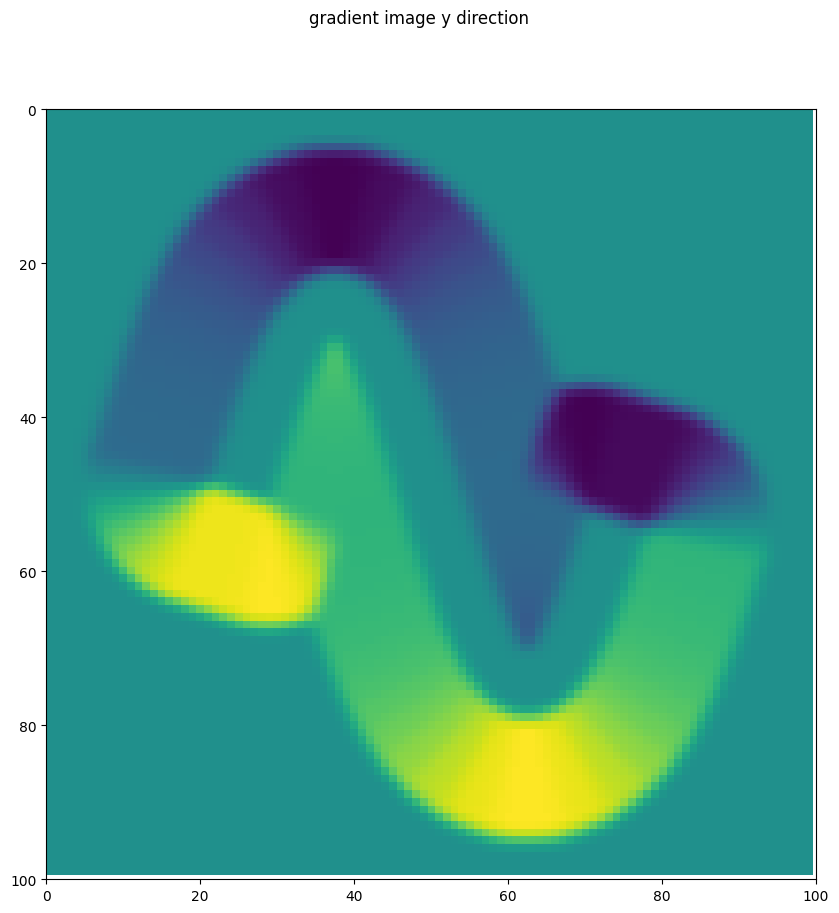

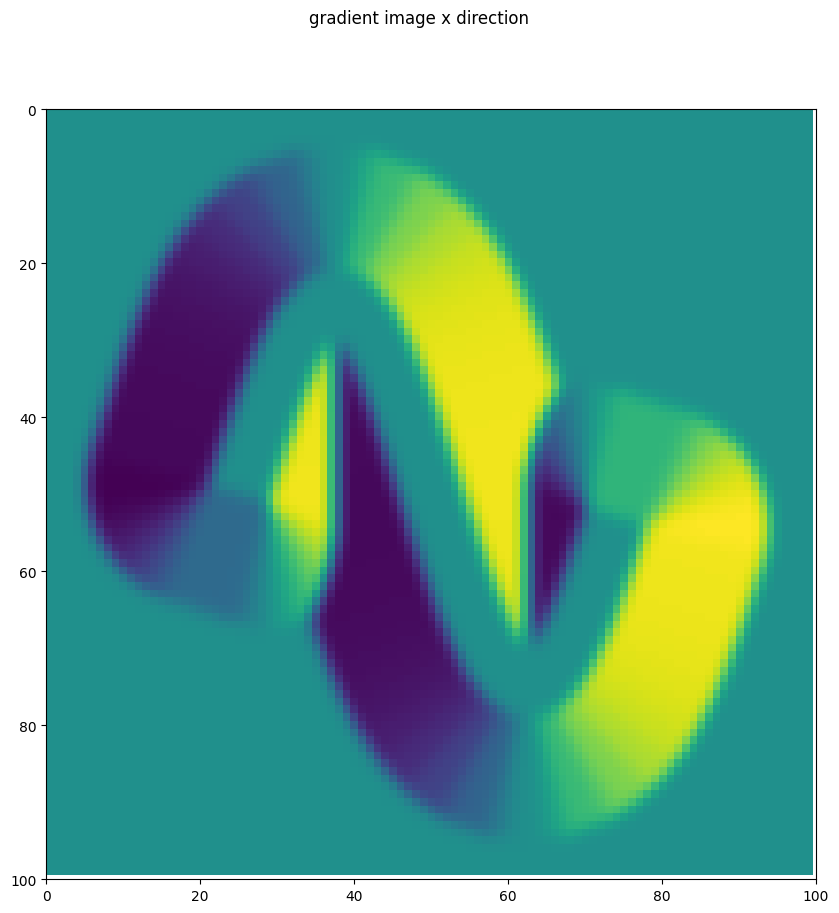

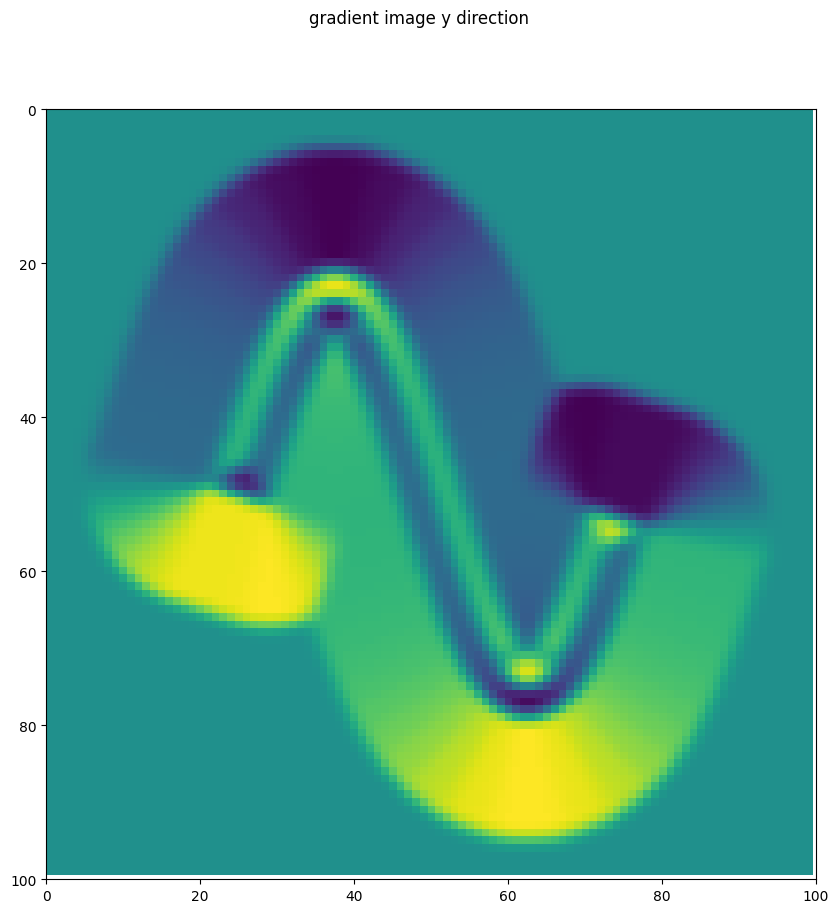

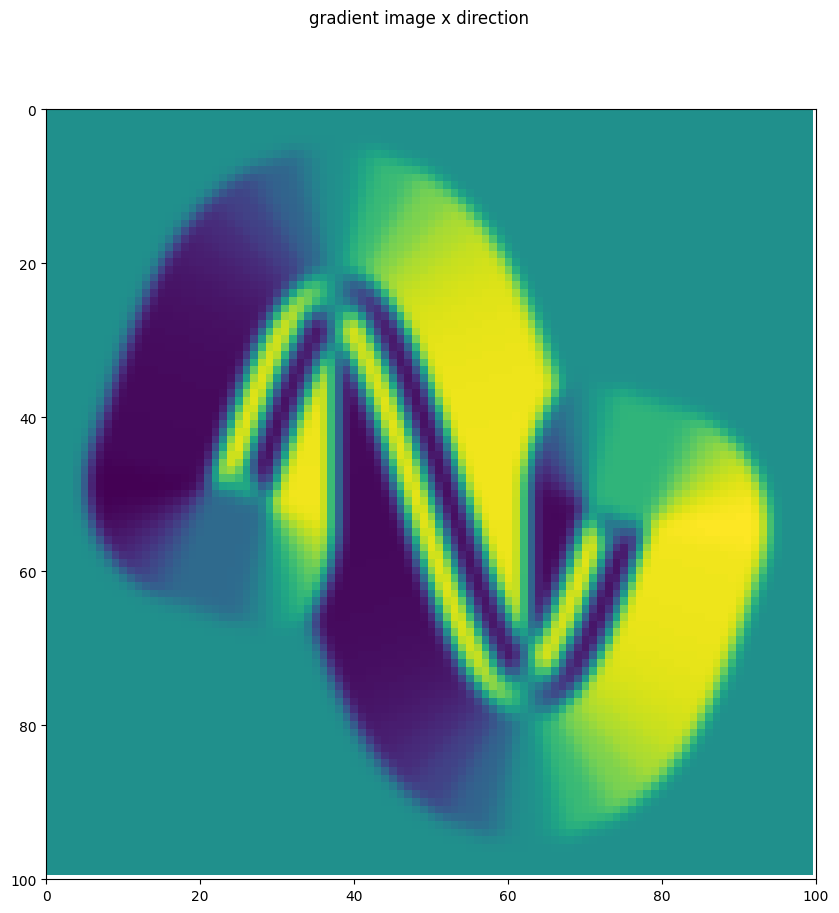

In [158]:
fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimg = cmptGradIm(pred,fltrtr)
gimgw = cmptGradIm(pred_w,fltrtr)

show(gimg[0][0].detach().numpy(),"gradient image y direction")
show(gimg[0][1].detach().numpy(),"gradient image x direction")

show(gimgw[0][0].detach().numpy(),"gradient image y direction")
show(gimgw[0][1].detach().numpy(),"gradient image x direction")

extgradfac=1.0
gimg = gimg[0]
gimgw = gimgw[0]

croprib=[slice(0,200), slice(0,200)]

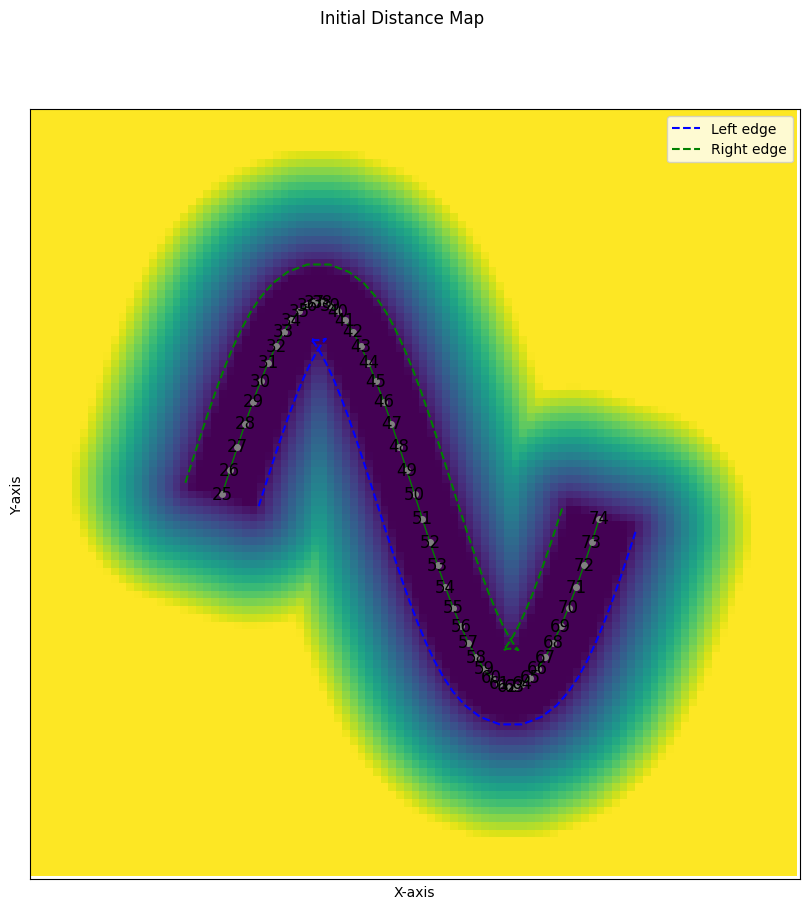

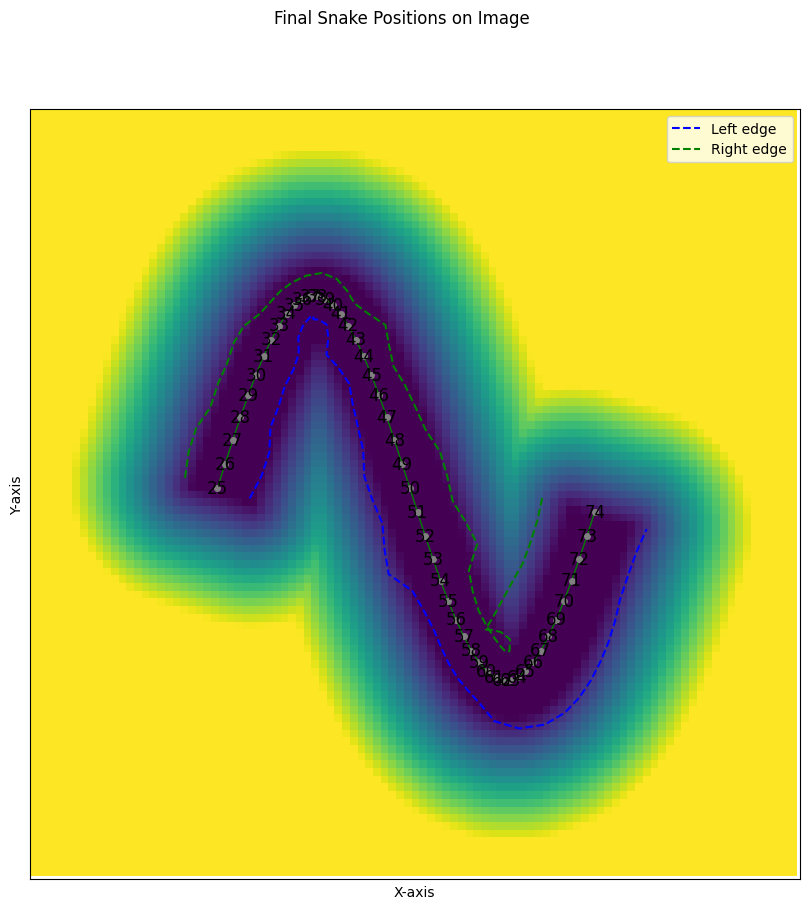

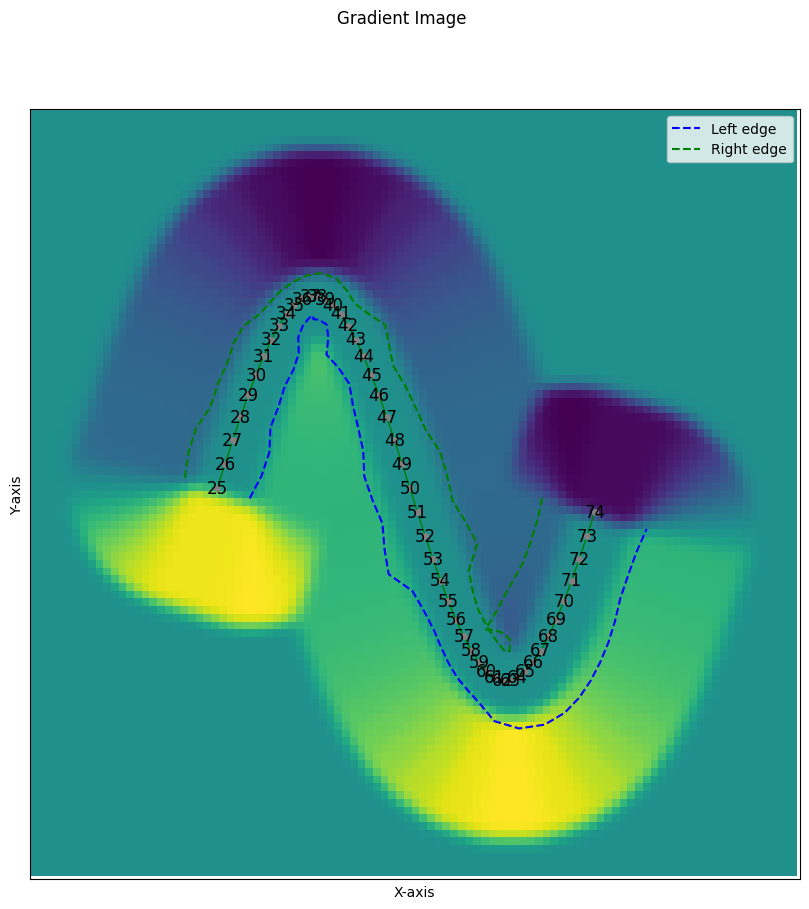

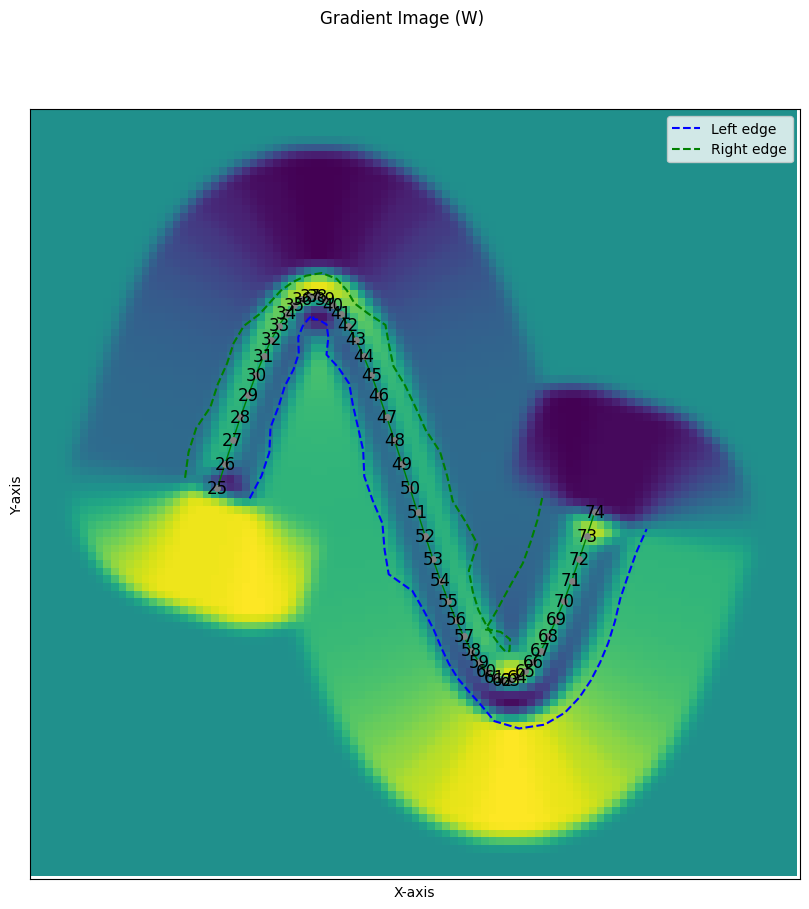

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


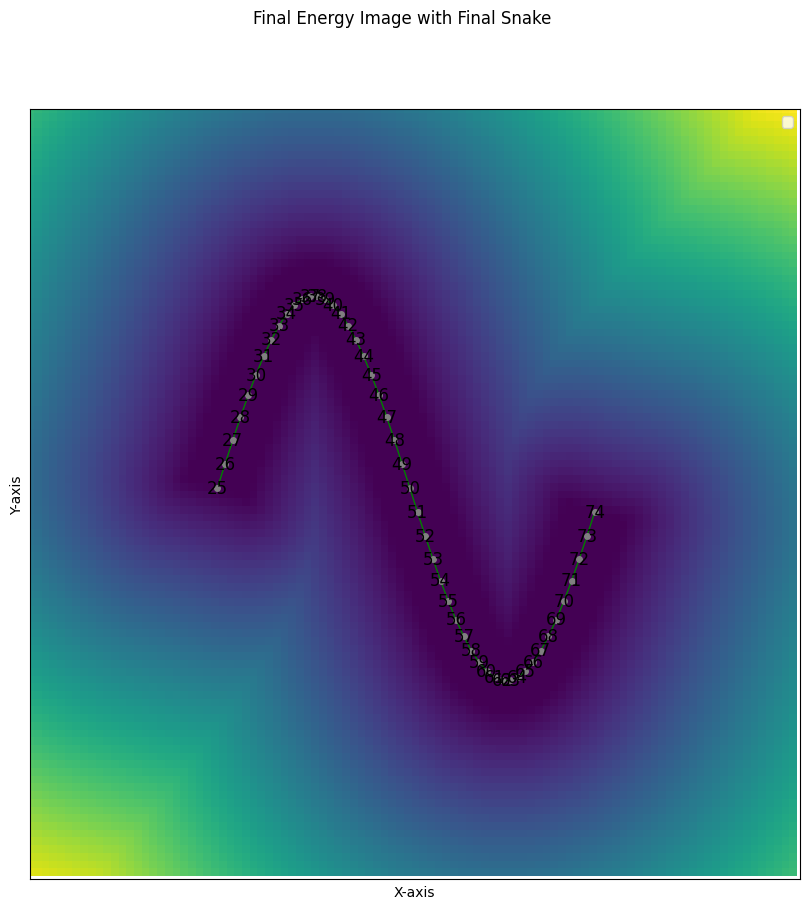

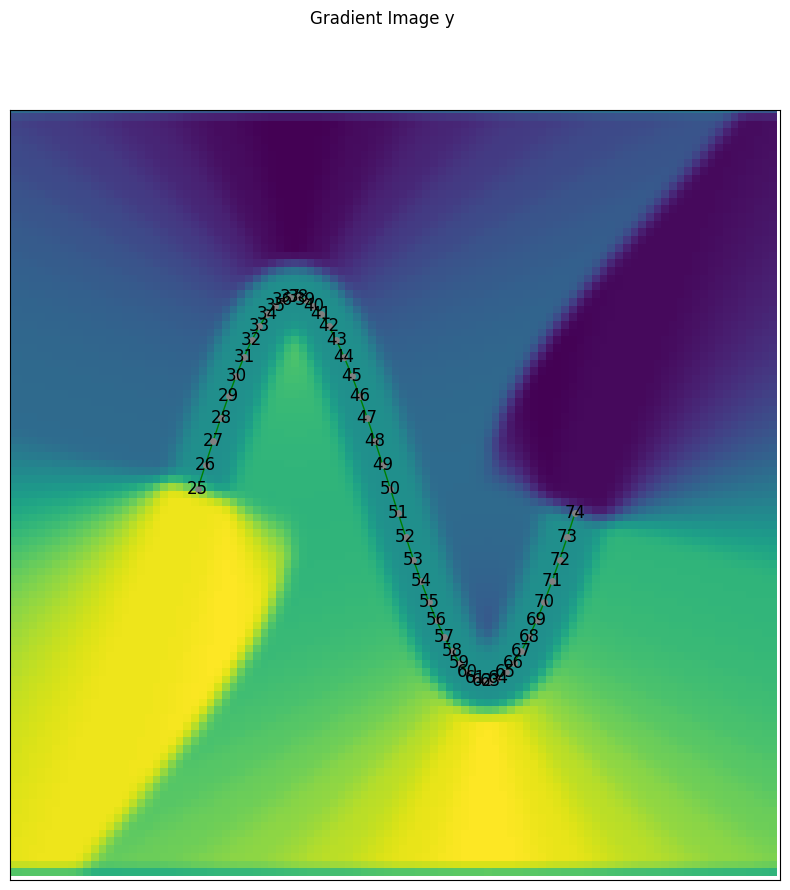

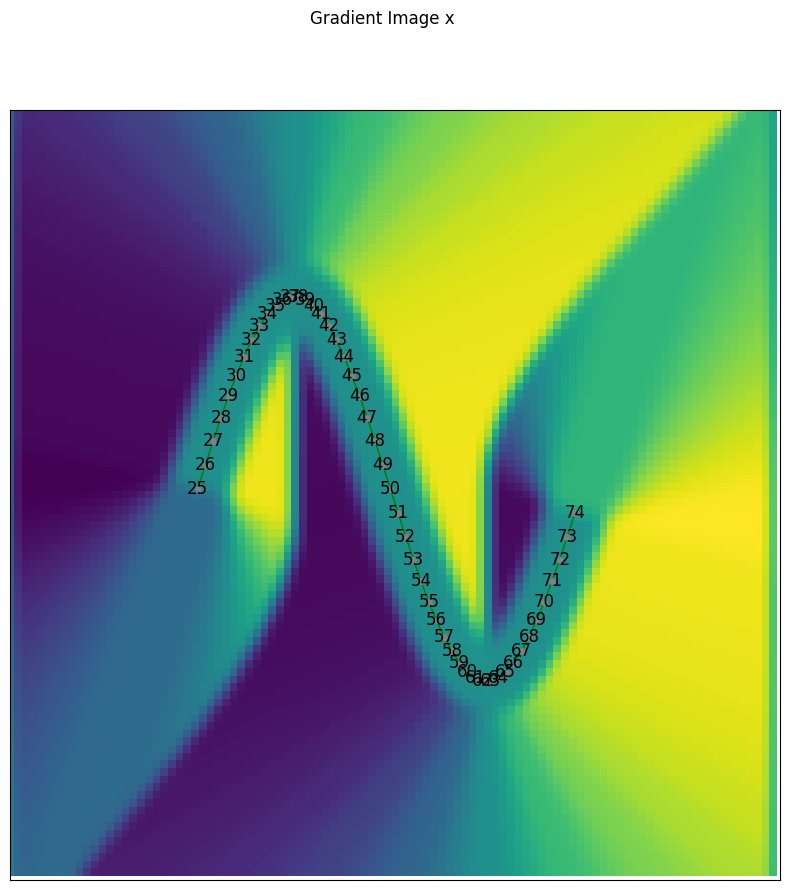

In [163]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimgW, step_type="stiff")
#sb.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w / 2.0 * norms_prev).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w / 2.0 * norms_prev).detach().cpu().numpy()
showriba(pred[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(1000)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms / 2).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimg[0].detach().cpu().numpy(), 'Gradient Image', sb.getGraph(), v_L, v_R)
showriba(gimgw[0].detach().cpu().numpy(), 'Gradient Image (W)', sb.getGraph(), v_L, v_R)

gra_res = sb.getGraph()
nodes_res = [gra_res.nodes[n]['pos'] for n in gra_res.nodes()]
widths_res = s.get_w().flatten()
samples_to_widths_res = list(zip(nodes_res, widths_res))
dist_map_res = render_distance_map_2d1F(samples_to_widths_res, [100, 100], norms_prev)
showriba(dist_map_res.detach().cpu().numpy(), 'Final Energy Image with Final Snake', gra_res)

gimg_res = cmptGradIm(dist_map_res.clone()[None,None], fltrtr)
show(gimg_res[0][0].detach().numpy(), 'Gradient Image y', gra_res)
show(gimg_res[0][1].detach().numpy(), 'Gradient Image x', gra_res)